## Pneumonia Detection from Chest X-Ray Images

**Team:**
* Raditya Fahritama

**Course:** Deep Learning (Fall II, 2022)

### Problem Statement
* The objective of our project is to analyze the patient’s chest X-ray and identify whether the patient has pneumonia or not and classify the type of the pneumonia based on the image using CNN and Transfer Learning. We compare the performances of 14 different models in term of F1 scores, accuracy, and training time. we also compare 2 optimizers to see if the performances will be different from each other. 
	

### Data Collection
* Source(url): https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
* Short Description : The original data set from Kaggle. Containing various Chest X-Ray Images from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. the original data only focused on NORMAL and PNEUMONIA classes. we breakdown the dataset manually to three classes. which are NORMAL, BACTERIAL, and VIRAL

* Keywords: Pneumonia

### Required packages

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime
import time
'''
for dirname, _, filenames in os.walk('D:\COURSE MATERIALS\deep learning\project\pneumonia\chest_xray\chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
import cv2
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.layers import Input, Activation
from keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [3]:
tf.version.VERSION

'2.10.1'

In [4]:
import sys

print("User Current Version:-", sys.version)

User Current Version:- 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [7]:
!nvidia-smi

Mon Dec  5 19:53:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.37       Driver Version: 527.37       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0    34W /  N/A |   1001MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# image path
path = '/Users/USER-PC/newpneumonia/train/'

# categories
categories = os.listdir(path)
categories

['BACTERIAL', 'NORMAL', 'VIRAL']

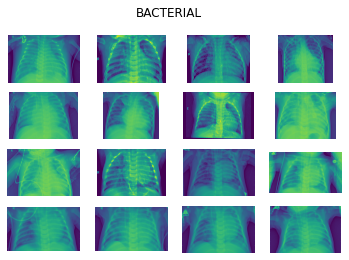

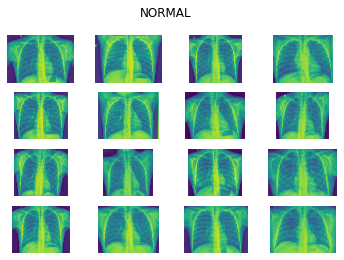

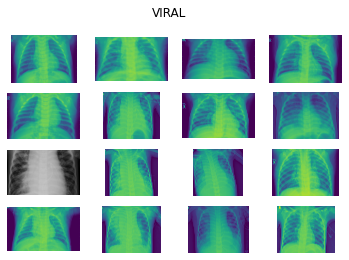

In [9]:
#showing some images
for category in categories:
    fig, _ = plt.subplots(4,4)
    fig.suptitle(category)
    for k, v in enumerate(os.listdir(path+category)[:16]):
        img = plt.imread(path+category+'/'+v)
        plt.subplot(4, 4, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

<BarContainer object of 3 artists>

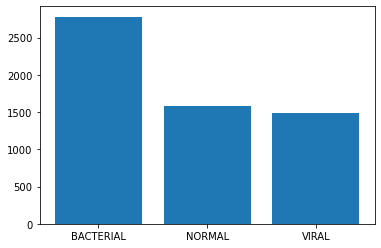

In [10]:
#showing data size for every category
data_size = {x: len(os.listdir(os.path.join(path, x))) for x in categories}
plt.bar(data_size.keys(), data_size.values())

In [11]:
#getting count of categories
count_bact = len(os.listdir(path+'//BACTERIAL'))
count_norm = len(os.listdir(path+'//NORMAL'))
count_vir = len(os.listdir(path+'//VIRAL'))

print("Number of BACTERIAL images : " + str(len(os.listdir(path+'//BACTERIAL')))) 
print("Number of NORMAL images : " + str(len(os.listdir(path+'//NORMAL'))))
print("Number of VIRAL images : " + str(len(os.listdir(path+'//VIRAL'))))

Number of BACTERIAL images : 2780
Number of NORMAL images : 1583
Number of VIRAL images : 1493


In [12]:
#assigning class weight to every category
weight_bact = count_bact / (count_vir + count_bact + count_norm)
weight_norm = count_norm / (count_vir + count_bact + count_norm)
weight_vir = count_vir / (count_vir + count_bact + count_norm)

class_weight = {0: weight_bact, 1: weight_norm, 2: weight_vir}

print(f"Weight for bacterial class: {weight_bact:.5f}")
print(f"Weight for normal class: {weight_norm:.5f}")
print(f"Weight for viral class: {weight_vir:.5f}")

Weight for bacterial class: 0.47473
Weight for normal class: 0.27032
Weight for viral class: 0.25495


In [13]:
#showing shape
bac_img = plt.imread(r'/Users/USER-PC/newpneumonia/train/BACTERIAL/person3_bacteria_10.jpeg')
bac_img.shape

(1056, 1248)

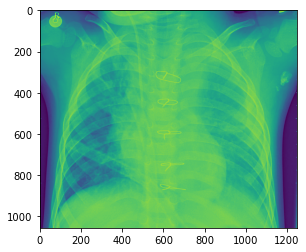

In [14]:
#showing example image
plt.imshow(bac_img)

C:\Users\USER-PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


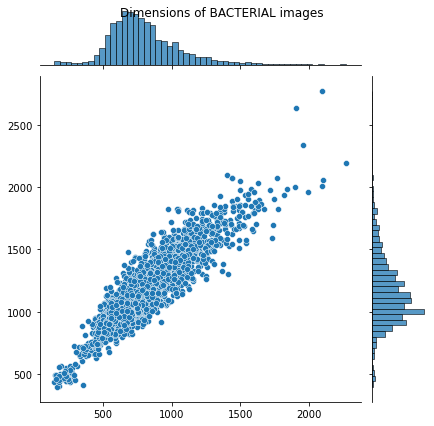

In [9]:
def explore_dimensions(path, labels):
    import seaborn as sns

    dim1 = []
    dim2 = []
    for image_filename in os.listdir(path+'//'+labels):    
      
        img = plt.imread(path+'//'+labels+'//'+image_filename)
        if len(img.shape)==2: 
            img = img.reshape(img.shape[0],img.shape[1],1)
        d1,d2,colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
    p = sns.jointplot(dim1,dim2)
    p.fig.suptitle("Dimensions of "+labels+ " images")

explore_dimensions(path, 'BACTERIAL')

C:\Users\USER-PC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

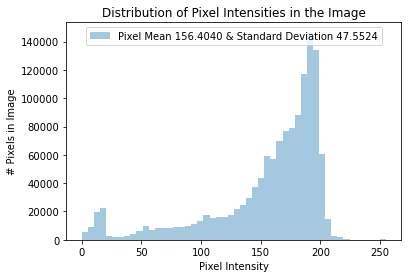

In [15]:
#getting pixel intensity

sns.distplot(bac_img.ravel(),
            label=f"Pixel Mean {np.mean(bac_img):.4f} & Standard Deviation {np.std(bac_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [16]:
#assigning shapes of image and batch size
height = 200
width = 200
channels = 3
shape = (height, width, channels)
batch_size = 64

# Image Preprocessing

In [17]:
#image prerprocessing

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import *

image_generator = ImageDataGenerator(
    
    validation_split=0.2,
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,
    samplewise_center=True,
    samplewise_std_normalization=True 
)


'''
image_generator = ImageDataGenerator(
                                  validation_split=0.2,
                                  rescale = 1/255,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  fill_mode = 'constant',
                                  zoom_range = 0.2,
                                  rotation_range = 10)
'''

"\nimage_generator = ImageDataGenerator(\n                                  validation_split=0.2,\n                                  rescale = 1/255,\n                                  width_shift_range = 0.1,\n                                  height_shift_range = 0.1,\n                                  fill_mode = 'constant',\n                                  zoom_range = 0.2,\n                                  rotation_range = 10)\n"

In [18]:
#assign image flow to train test validation

trainfl = image_generator.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batch_size, 
    classes=categories,
    shuffle=True,
    subset='training')

testfl = image_generator.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batch_size, 
    classes=categories,
    shuffle=False,
    subset='validation')

valfl = image_generator.flow_from_directory(
    path,
    target_size=(height, width),
    batch_size=batch_size, 
    classes=categories,
    shuffle=True,
    subset='validation')


Found 4686 images belonging to 3 classes.
Found 1170 images belonging to 3 classes.
Found 1170 images belonging to 3 classes.


In [19]:
trainfl.samples 

4686

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 200 pixels width and 200 pixels height, one single color channel.


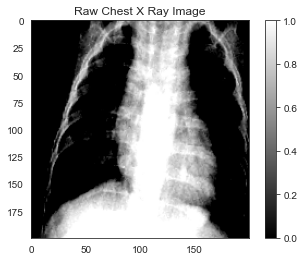

In [20]:
sns.set_style('white')
generated_image, label = trainfl.__getitem__(2)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")

100%|██████████| 3/3 [00:00<00:00, 499.80it/s]


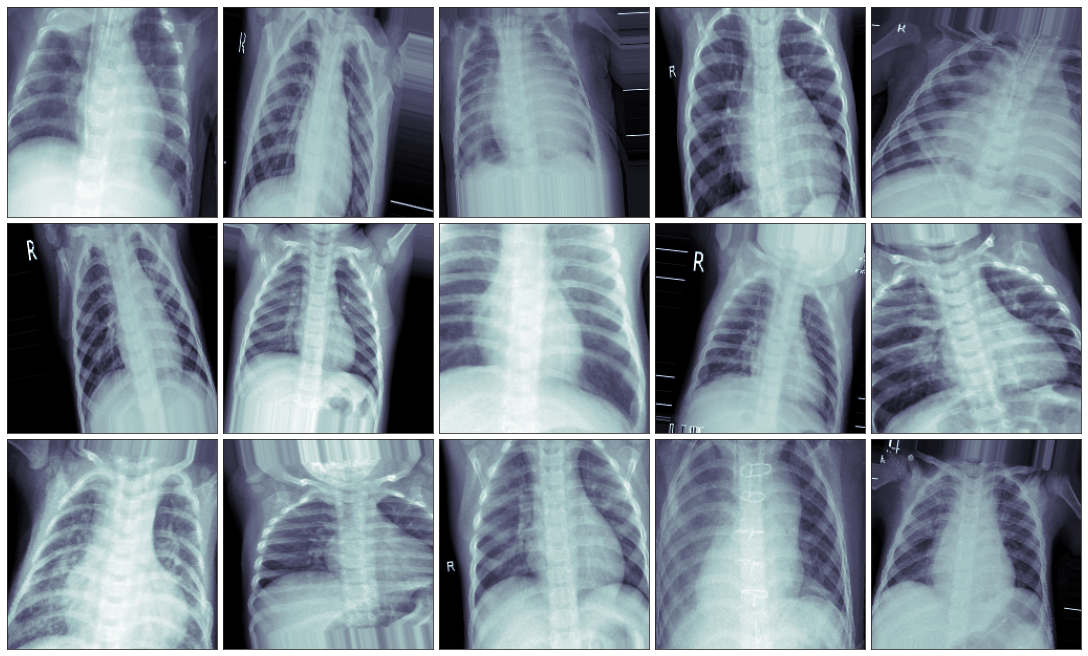

In [21]:
from tqdm import tqdm

images, dlabels = trainfl.next()

n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(images[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

In [22]:
#getting images without data augmentation

data = []
labels = []
imagePaths = []

for k, category in enumerate(categories):
    for f in os.listdir(path+category):
        imagePaths.append([path+category+'/'+f, k]) 

random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (width, height)) 
    data.append(image)
    label = imagePath[1]
    labels.append(label)

In [23]:
#transforming the image to array and scaling it

datascaled = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
labels = np.unique(labels, return_inverse=True)[1].tolist()
labels = np.array(labels, dtype="int")

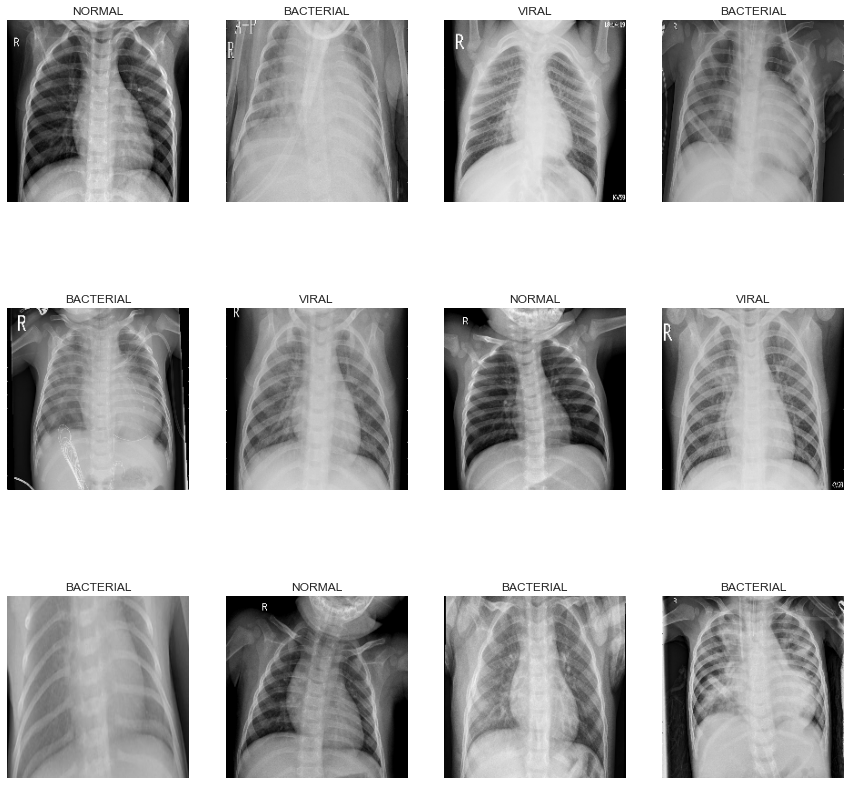

In [24]:
plt.subplots(3,4, figsize=(15, 15))
for i in range(0,12):
    plt.subplot(3,4, i+1)
    plt.imshow(datascaled[i])
    plt.axis('off')
    plt.title(categories[labels[i]])
plt.show()

In [25]:
#split the data to train and test for non augmented
(x_train, x_test, y_train, y_test) = train_test_split(datascaled, labels, test_size=0.2, random_state=42)

In [26]:
# Preprocess class labels
y_train = np_utils.to_categorical(y_train, 3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4684, 200, 200, 3)
(1172, 200, 200, 3)
(4684, 3)
(1172,)


In [27]:
#create comparison dataframe
comparisondf = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC score', 'Training Time'])

In [28]:
#confusion matrix function
def confmat(cm):
    ax = sns.heatmap(cm, annot=True, cmap='YlOrBr')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(categories)
    ax.yaxis.set_ticklabels(categories)

    plt.show()

In [29]:
#function to compile model with adam
def modelcompile(model):
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'categorical_crossentropy'])
    print(model.summary())

In [30]:
#function to compile model with RMSprop
def modelcompile2(model):
    opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'categorical_crossentropy'])
    print(model.summary())


In [31]:
#function to plot accuracy and loss plot
def acclossplot(trainfit):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(trainfit.history['loss'], label='Loss')
    plt.plot(trainfit.history['val_loss'], label='Val_Loss')
    plt.legend()
    plt.title('Loss Evolution')

    plt.subplot(2, 2, 2)
    plt.plot(trainfit.history['accuracy'], label='Accuracy')
    plt.plot(trainfit.history['val_accuracy'], label='Val_Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

In [32]:
#function to evaluate model
def simpleeval(model):   
    evaluation = model.evaluate(testfl)
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

    evaluation = model.evaluate(trainfl)
    print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

In [33]:
#function to earlystop and restore best weights
def earlystop(path):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, 
                                                       save_weights_only=False,
                                                       save_freq='epoch',
                                                       monitor='val_accuracy',
                                                       mode='max',
                                                       save_best_only=True,
                                                       restore_best_weights=True)
    return early_stopping, ckpt_callback

In [34]:
#function to get classification report
def classreport(report):
    macro_precision =  round(report['macro avg']['precision'],2)
    macro_recall = round(report['macro avg']['recall'],2)  
    macro_f1 = round(report['macro avg']['f1-score'],2)
    accuracy = round(report['accuracy'],2)
    return macro_precision, macro_recall, macro_f1, accuracy

In [35]:
#function to get the ROC curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(testfl.class_indices):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)

### Methodology

- #### MODELS USED

    #### Convolutional Neural Network (CNN)

    Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics. 
    
    #### Transfer Learning
    
    Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data. Transfer learning is so common that it is rare to train a model for an image or natural language processing-related tasks from scratch.
    
    Transfer Learning Models that we use:
    
    - VGG16
    - ResNet
    - DenseNet
    - InceptionV3
    - XCeption

# Baseline CNN


In [36]:
def basecnn():
    tf.keras.backend.clear_session()

    base = Sequential()

    base.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
    base.add(layers.MaxPooling2D((2, 2)))
    base.add(layers.Conv2D(64, (3, 3), activation='relu'))
    base.add(layers.MaxPooling2D((2, 2)))
    base.add(layers.Conv2D(128, (3, 3), activation='relu'))
    base.add(layers.MaxPooling2D((2, 2)))
    base.add(layers.Conv2D(256, (3, 3), activation='relu'))
    base.add(layers.MaxPooling2D((2, 2)))
    base.add(layers.Flatten())
    base.add(layers.Dropout(0.1))
    base.add(layers.Dense(256, activation='relu'))
    base.add(layers.Dropout(0.1))
    base.add(layers.Dense(128, activation='relu'))
    base.add(layers.Dropout(0.1))
    base.add(layers.Dense(64, activation='relu'))
    base.add(layers.Dropout(0.1))
    base.add(layers.Dense(32, activation='relu'))
    base.add(layers.Dropout(0.2))
    base.add(Dense(3, activation='softmax'))
    
    return base

## without augmentation - adam

In [37]:
#get model and compile
basemodel = basecnn()
modelcompile(basemodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [38]:
#train the model
es, ck = earlystop('./ckpt_model1')
now1 = datetime.now()
trainbase1 = basemodel.fit(x_train,
              y_train, 
              epochs=20,
              validation_split = 0.2,
              validation_steps = valfl.samples // batch_size,
              class_weight=class_weight,
              steps_per_epoch = trainfl.samples // batch_size,
              callbacks = [es, ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.4782 - categorical_crossentropy: 1.0707

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 19s 140ms/step - loss: 0.3400 - accuracy: 0.4782 - categorical_crossentropy: 1.0707 - val_loss: 0.8984 - val_accuracy: 0.5977 - val_categorical_crossentropy: 0.8984
Epoch 2/20
72/73 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.6295 - categorical_crossentropy: 0.8529

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 6s 87ms/step - loss: 0.2652 - accuracy: 0.6293 - categorical_crossentropy: 0.8533 - val_loss: 0.6558 - val_accuracy: 0.7172 - val_categorical_crossentropy: 0.6558
Epoch 3/20
73/73 [==============================] - 5s 65ms/step - loss: 0.2159 - accuracy: 0.7027 - categorical_crossentropy: 0.6971 - val_loss: 0.6867 - val_accuracy: 0.7044 - val_categorical_crossentropy: 0.6867
Epoch 4/20
72/73 [============================>.] - ETA: 0s - loss: 0.2010 - accuracy: 0.7217 - categorical_crossentropy: 0.6565

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 6s 86ms/step - loss: 0.2009 - accuracy: 0.7219 - categorical_crossentropy: 0.6562 - val_loss: 0.6255 - val_accuracy: 0.7375 - val_categorical_crossentropy: 0.6255
Epoch 5/20
72/73 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.7479 - categorical_crossentropy: 0.6123

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 6s 84ms/step - loss: 0.1879 - accuracy: 0.7481 - categorical_crossentropy: 0.6121 - val_loss: 0.5606 - val_accuracy: 0.7673 - val_categorical_crossentropy: 0.5606
Epoch 6/20
72/73 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.7660 - categorical_crossentropy: 0.5863

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 6s 86ms/step - loss: 0.1803 - accuracy: 0.7659 - categorical_crossentropy: 0.5862 - val_loss: 0.5361 - val_accuracy: 0.7812 - val_categorical_crossentropy: 0.5361
Epoch 7/20
72/73 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.7762 - categorical_crossentropy: 0.5547

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 6s 87ms/step - loss: 0.1728 - accuracy: 0.7764 - categorical_crossentropy: 0.5544 - val_loss: 0.5122 - val_accuracy: 0.7962 - val_categorical_crossentropy: 0.5122
Epoch 8/20
73/73 [==============================] - 5s 67ms/step - loss: 0.1685 - accuracy: 0.7785 - categorical_crossentropy: 0.5464 - val_loss: 0.5052 - val_accuracy: 0.7919 - val_categorical_crossentropy: 0.5052
Epoch 9/20
73/73 [==============================] - 5s 64ms/step - loss: 0.1627 - accuracy: 0.7924 - categorical_crossentropy: 0.5247 - val_loss: 0.5289 - val_accuracy: 0.7812 - val_categorical_crossentropy: 0.5289
Epoch 10/20
73/73 [==============================] - 5s 63ms/step - loss: 0.1588 - accuracy: 0.7926 - categorical_crossentropy: 0.5146 - val_loss: 0.5218 - val_accuracy: 0.7791 - val_categorical_crossentropy: 0.5218


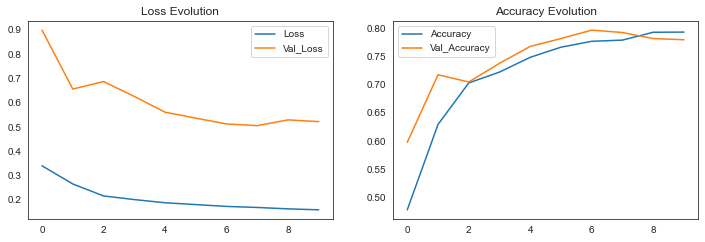

In [39]:
acclossplot(trainbase1)

In [40]:
#get the classification report
basepred = basemodel.predict(x_test)
basepred = np.argmax(basepred,axis = 1)
accuracy = accuracy_score(y_test, basepred)
print("\nAccuracy : %.2f%% \n" % (accuracy*100.0))
print(classification_report(y_test, basepred, target_names = categories))
report = classification_report(y_test, basepred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

37/37 [==============================] - 1s 18ms/step

Accuracy : 78.58% 

              precision    recall  f1-score   support

   BACTERIAL       0.77      0.88      0.82       569
      NORMAL       0.88      0.95      0.91       309
       VIRAL       0.69      0.44      0.54       294

    accuracy                           0.79      1172
   macro avg       0.78      0.76      0.76      1172
weighted avg       0.78      0.79      0.77      1172



[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'True'),
 Text(0.5, 1.0, 'Confusion Matrix\n\n')]

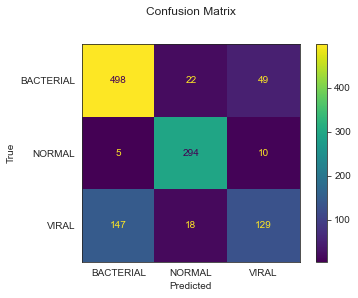

In [41]:
#displaying confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, basepred), display_labels=categories)
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix\n\n')

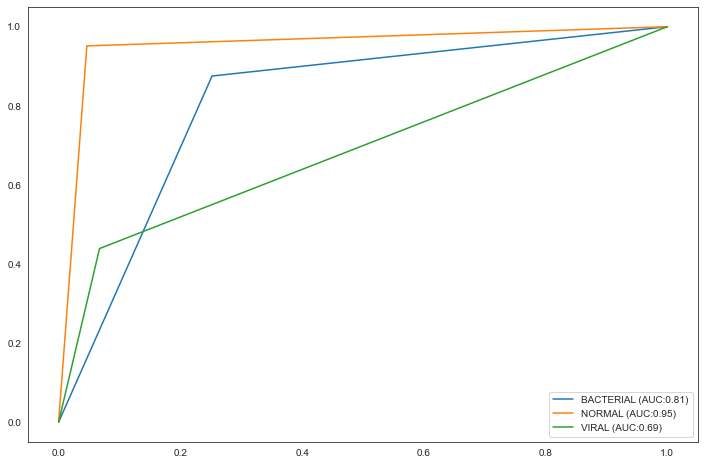

In [42]:
#get ROC of the model
roc = multiclass_roc_auc_score(y_test, basepred)

In [43]:
#assign values to the comparison dataframe
comparisondf.loc[len(comparisondf)] = ['CNN-ADAM', precision, recall, f1, accuracy, roc,  timediff]

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.78,0.76,0.76,0.79,0.816638,0:01:23.254390


In [46]:
basemodel.save('bestmodel.h5')

Rest of the models are the same in term of code structure

## without augmentation - rmsprop

In [89]:
basemodelrms = basecnn()
modelcompile2(basemodelrms)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [90]:
es, ck = earlystop('./ckpt_model1')
now1 = datetime.now()
trainbase1rms = basemodelrms.fit(x_train,
              y_train, 
              epochs=20,
              validation_split = 0.2,
              validation_steps = valfl.samples // batch_size,
              class_weight=class_weight,
              steps_per_epoch = trainfl.samples // batch_size,
              callbacks = [es, ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
72/73 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.4992 - categorical_crossentropy: 1.0544

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 11s 131ms/step - loss: 0.3323 - accuracy: 0.4993 - categorical_crossentropy: 1.0541 - val_loss: 1.0955 - val_accuracy: 0.4664 - val_categorical_crossentropy: 1.0955
Epoch 2/20
72/73 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.6480 - categorical_crossentropy: 0.8266

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 7s 94ms/step - loss: 0.2518 - accuracy: 0.6477 - categorical_crossentropy: 0.8268 - val_loss: 0.9597 - val_accuracy: 0.5454 - val_categorical_crossentropy: 0.9597
Epoch 3/20
72/73 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.7017 - categorical_crossentropy: 0.7058

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 7s 93ms/step - loss: 0.2153 - accuracy: 0.7016 - categorical_crossentropy: 0.7059 - val_loss: 0.6296 - val_accuracy: 0.7012 - val_categorical_crossentropy: 0.6296
Epoch 4/20
72/73 [============================>.] - ETA: 0s - loss: 0.1968 - accuracy: 0.7286 - categorical_crossentropy: 0.6444

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 7s 96ms/step - loss: 0.1969 - accuracy: 0.7286 - categorical_crossentropy: 0.6444 - val_loss: 0.6100 - val_accuracy: 0.7428 - val_categorical_crossentropy: 0.6100
Epoch 5/20
72/73 [============================>.] - ETA: 0s - loss: 0.1858 - accuracy: 0.7476 - categorical_crossentropy: 0.6056

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 7s 94ms/step - loss: 0.1859 - accuracy: 0.7473 - categorical_crossentropy: 0.6057 - val_loss: 0.5741 - val_accuracy: 0.7524 - val_categorical_crossentropy: 0.5741
Epoch 6/20
72/73 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.7535 - categorical_crossentropy: 0.5757

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 7s 94ms/step - loss: 0.1776 - accuracy: 0.7534 - categorical_crossentropy: 0.5759 - val_loss: 0.5263 - val_accuracy: 0.7609 - val_categorical_crossentropy: 0.5263
Epoch 7/20
73/73 [==============================] - 5s 73ms/step - loss: 0.1724 - accuracy: 0.7667 - categorical_crossentropy: 0.5589 - val_loss: 0.5965 - val_accuracy: 0.7343 - val_categorical_crossentropy: 0.5965
Epoch 8/20
72/73 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.7695 - categorical_crossentropy: 0.5391

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 7s 97ms/step - loss: 0.1675 - accuracy: 0.7689 - categorical_crossentropy: 0.5411 - val_loss: 0.5161 - val_accuracy: 0.7823 - val_categorical_crossentropy: 0.5161
Epoch 9/20
73/73 [==============================] - 5s 73ms/step - loss: 0.1632 - accuracy: 0.7774 - categorical_crossentropy: 0.5257 - val_loss: 0.7634 - val_accuracy: 0.6926 - val_categorical_crossentropy: 0.7634
Epoch 10/20
73/73 [==============================] - 5s 73ms/step - loss: 0.1560 - accuracy: 0.7894 - categorical_crossentropy: 0.5095 - val_loss: 0.7850 - val_accuracy: 0.6713 - val_categorical_crossentropy: 0.7850
Epoch 11/20
73/73 [==============================] - 5s 73ms/step - loss: 0.1534 - accuracy: 0.7926 - categorical_crossentropy: 0.4967 - val_loss: 0.4935 - val_accuracy: 0.7748 - val_categorical_crossentropy: 0.4935
Epoch 12/20
73/73 [==============================] - 5s 73ms/step - loss: 0.1492 - accuracy: 0.7940 - categorical_crossentropy: 0.4829 - val_loss: 0.

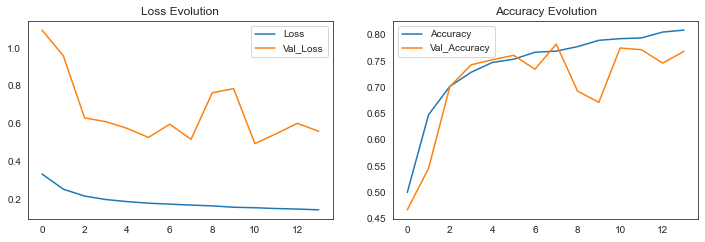

In [91]:
acclossplot(trainbase1rms)

In [92]:
basepredrms = basemodelrms.predict(x_test)
basepredrms = np.argmax(basepredrms,axis = 1)
accuracy = accuracy_score(y_test, basepredrms)
print("\nAccuracy : %.2f%% \n" % (accuracy*100.0))
print(classification_report(y_test, basepredrms, target_names = categories))
report = classification_report(y_test, basepredrms, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

37/37 [==============================] - 1s 21ms/step

Accuracy : 79.27% 

              precision    recall  f1-score   support

   BACTERIAL       0.75      0.92      0.83       568
      NORMAL       0.91      0.92      0.91       322
       VIRAL       0.72      0.40      0.51       282

    accuracy                           0.79      1172
   macro avg       0.79      0.75      0.75      1172
weighted avg       0.79      0.79      0.78      1172



[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'True'),
 Text(0.5, 1.0, 'Confusion Matrix\n\n')]

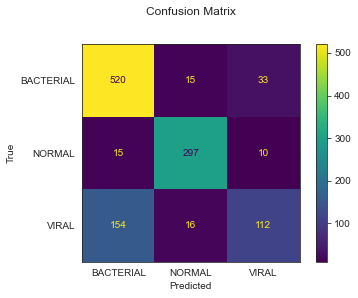

In [93]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, basepredrms), display_labels=categories)
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix\n\n')

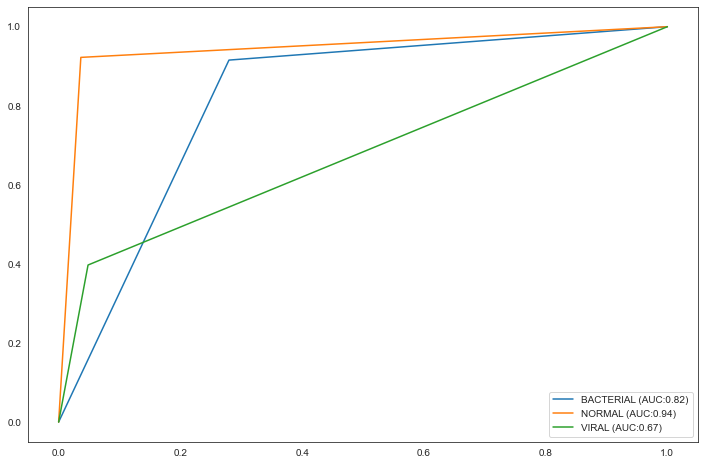

In [94]:
roc = multiclass_roc_auc_score(y_test, basepredrms)

In [95]:
comparisondf.loc[len(comparisondf)] = ['CNN-RMSPROP', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

# With augmentation - adam

In [116]:
basemodel = basecnn()
modelcompile(basemodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [117]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_model1')
trainbase2 = basemodel.fit(
          trainfl,
          epochs=20,
          validation_data=valfl,
          validation_steps = valfl.samples // batch_size,
          class_weight=class_weight,
          steps_per_epoch = trainfl.samples // batch_size,
          callbacks=[es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.5219 - categorical_crossentropy: 0.9977

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 80s 1s/step - loss: 0.3145 - accuracy: 0.5219 - categorical_crossentropy: 0.9977 - val_loss: 0.8249 - val_accuracy: 0.6424 - val_categorical_crossentropy: 0.8249
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.6285 - categorical_crossentropy: 0.8398

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 80s 1s/step - loss: 0.2606 - accuracy: 0.6285 - categorical_crossentropy: 0.8398 - val_loss: 0.8012 - val_accuracy: 0.6484 - val_categorical_crossentropy: 0.8012
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.6573 - categorical_crossentropy: 0.7816

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 73s 1s/step - loss: 0.2420 - accuracy: 0.6573 - categorical_crossentropy: 0.7816 - val_loss: 0.7122 - val_accuracy: 0.6771 - val_categorical_crossentropy: 0.7122
Epoch 4/20
73/73 [==============================] - 72s 985ms/step - loss: 0.2355 - accuracy: 0.6573 - categorical_crossentropy: 0.7626 - val_loss: 0.7658 - val_accuracy: 0.6519 - val_categorical_crossentropy: 0.7658
Epoch 5/20
73/73 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.6653 - categorical_crossentropy: 0.7463

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 78s 1s/step - loss: 0.2300 - accuracy: 0.6653 - categorical_crossentropy: 0.7463 - val_loss: 0.6779 - val_accuracy: 0.6797 - val_categorical_crossentropy: 0.6779
Epoch 6/20
73/73 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.6820 - categorical_crossentropy: 0.7051

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 80s 1s/step - loss: 0.2170 - accuracy: 0.6820 - categorical_crossentropy: 0.7051 - val_loss: 0.6682 - val_accuracy: 0.6806 - val_categorical_crossentropy: 0.6682
Epoch 7/20
73/73 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.6841 - categorical_crossentropy: 0.7040

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 81s 1s/step - loss: 0.2160 - accuracy: 0.6841 - categorical_crossentropy: 0.7040 - val_loss: 0.6705 - val_accuracy: 0.6918 - val_categorical_crossentropy: 0.6705
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.6887 - categorical_crossentropy: 0.6823

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 81s 1s/step - loss: 0.2101 - accuracy: 0.6887 - categorical_crossentropy: 0.6823 - val_loss: 0.6530 - val_accuracy: 0.7023 - val_categorical_crossentropy: 0.6530
Epoch 9/20
73/73 [==============================] - 79s 1s/step - loss: 0.2053 - accuracy: 0.6954 - categorical_crossentropy: 0.6663 - val_loss: 0.6585 - val_accuracy: 0.6936 - val_categorical_crossentropy: 0.6585
Epoch 10/20
73/73 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.7109 - categorical_crossentropy: 0.6418

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 76s 1s/step - loss: 0.1975 - accuracy: 0.7109 - categorical_crossentropy: 0.6418 - val_loss: 0.6522 - val_accuracy: 0.7300 - val_categorical_crossentropy: 0.6522
Epoch 11/20
73/73 [==============================] - 73s 1s/step - loss: 0.1977 - accuracy: 0.7159 - categorical_crossentropy: 0.6426 - val_loss: 0.6436 - val_accuracy: 0.7188 - val_categorical_crossentropy: 0.6436
Epoch 12/20
73/73 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.7341 - categorical_crossentropy: 0.6170

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 72s 987ms/step - loss: 0.1895 - accuracy: 0.7341 - categorical_crossentropy: 0.6170 - val_loss: 0.5954 - val_accuracy: 0.7457 - val_categorical_crossentropy: 0.5954
Epoch 13/20
73/73 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.7248 - categorical_crossentropy: 0.6298

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 73s 1s/step - loss: 0.1941 - accuracy: 0.7248 - categorical_crossentropy: 0.6298 - val_loss: 0.6113 - val_accuracy: 0.7491 - val_categorical_crossentropy: 0.6113
Epoch 14/20
73/73 [==============================] - 72s 990ms/step - loss: 0.1906 - accuracy: 0.7415 - categorical_crossentropy: 0.6175 - val_loss: 0.6017 - val_accuracy: 0.7491 - val_categorical_crossentropy: 0.6017
Epoch 15/20
73/73 [==============================] - 72s 979ms/step - loss: 0.1895 - accuracy: 0.7417 - categorical_crossentropy: 0.6170 - val_loss: 0.5977 - val_accuracy: 0.7361 - val_categorical_crossentropy: 0.5977


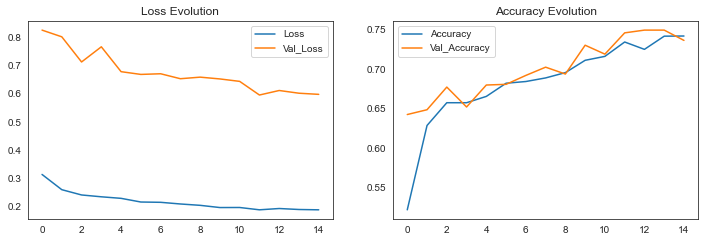

In [118]:
acclossplot(trainbase2)

In [119]:
basepred = basemodel.predict(testfl)
basepred = np.argmax(basepred,axis = 1)
print(classification_report(testfl.classes, basepred, target_names = categories))
report = classification_report(testfl.classes, basepred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 15s 769ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.69      0.95      0.80       556
      NORMAL       0.86      0.89      0.87       316
       VIRAL       0.78      0.20      0.32       298

    accuracy                           0.74      1170
   macro avg       0.78      0.68      0.66      1170
weighted avg       0.76      0.74      0.70      1170



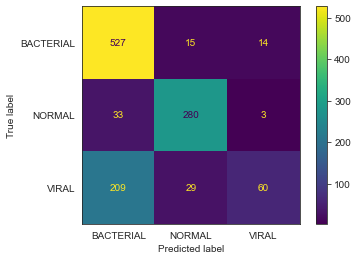

In [120]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, basepred), display_labels=categories)
disp.plot()

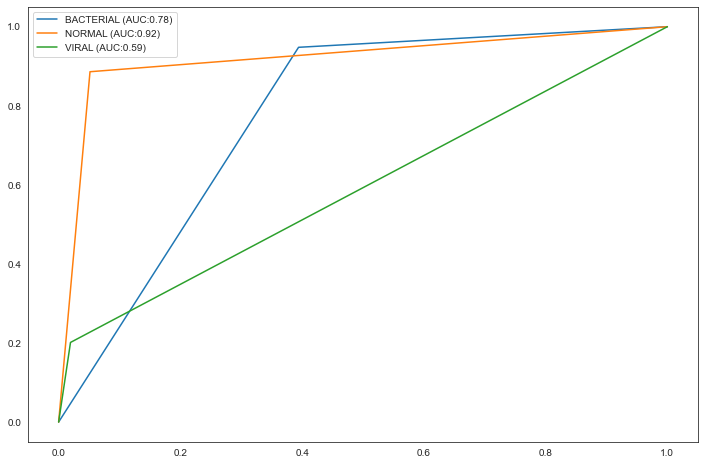

In [121]:
roc = multiclass_roc_auc_score(testfl.classes, basepred)

In [122]:
comparisondf.loc[len(comparisondf)] = ['CNN-ADAM-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096


# With augmentation - rmsprop

In [124]:
basemodelrms = basecnn()
modelcompile2(basemodelrms)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [125]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_model1')
trainbase2rms = basemodelrms.fit(
          trainfl,
          epochs=20,
          validation_data=valfl,
          validation_steps = valfl.samples // batch_size,
          class_weight=class_weight,
          steps_per_epoch = trainfl.samples // batch_size,
          callbacks=[es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.5318 - categorical_crossentropy: 1.0091

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 74s 1s/step - loss: 0.3170 - accuracy: 0.5318 - categorical_crossentropy: 1.0091 - val_loss: 0.8339 - val_accuracy: 0.6146 - val_categorical_crossentropy: 0.8339
Epoch 2/20
73/73 [==============================] - 69s 944ms/step - loss: 0.2707 - accuracy: 0.6209 - categorical_crossentropy: 0.8735 - val_loss: 0.8823 - val_accuracy: 0.6050 - val_categorical_crossentropy: 0.8823
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.6413 - categorical_crossentropy: 0.8323

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 70s 955ms/step - loss: 0.2589 - accuracy: 0.6413 - categorical_crossentropy: 0.8323 - val_loss: 0.7159 - val_accuracy: 0.6719 - val_categorical_crossentropy: 0.7159
Epoch 4/20
73/73 [==============================] - 71s 965ms/step - loss: 0.2444 - accuracy: 0.6543 - categorical_crossentropy: 0.7881 - val_loss: 0.7930 - val_accuracy: 0.6311 - val_categorical_crossentropy: 0.7930
Epoch 5/20
73/73 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.6692 - categorical_crossentropy: 0.7664

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 78s 1s/step - loss: 0.2360 - accuracy: 0.6692 - categorical_crossentropy: 0.7664 - val_loss: 0.6993 - val_accuracy: 0.6936 - val_categorical_crossentropy: 0.6993
Epoch 6/20
73/73 [==============================] - 75s 1s/step - loss: 0.2222 - accuracy: 0.6878 - categorical_crossentropy: 0.7174 - val_loss: 0.7250 - val_accuracy: 0.6806 - val_categorical_crossentropy: 0.7250
Epoch 7/20
73/73 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.7003 - categorical_crossentropy: 0.6998

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 74s 1s/step - loss: 0.2163 - accuracy: 0.7003 - categorical_crossentropy: 0.6998 - val_loss: 0.6515 - val_accuracy: 0.7231 - val_categorical_crossentropy: 0.6515
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.7036 - categorical_crossentropy: 0.6894

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 72s 991ms/step - loss: 0.2138 - accuracy: 0.7036 - categorical_crossentropy: 0.6894 - val_loss: 0.6122 - val_accuracy: 0.7387 - val_categorical_crossentropy: 0.6122
Epoch 9/20
73/73 [==============================] - 72s 980ms/step - loss: 0.2067 - accuracy: 0.7213 - categorical_crossentropy: 0.6650 - val_loss: 0.7314 - val_accuracy: 0.6823 - val_categorical_crossentropy: 0.7314
Epoch 10/20
73/73 [==============================] - 78s 1s/step - loss: 0.2026 - accuracy: 0.7296 - categorical_crossentropy: 0.6563 - val_loss: 0.6503 - val_accuracy: 0.7188 - val_categorical_crossentropy: 0.6503
Epoch 11/20
73/73 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.7354 - categorical_crossentropy: 0.6360

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 73s 1000ms/step - loss: 0.1974 - accuracy: 0.7354 - categorical_crossentropy: 0.6360 - val_loss: 0.6022 - val_accuracy: 0.7561 - val_categorical_crossentropy: 0.6022
Epoch 12/20
73/73 [==============================] - 72s 984ms/step - loss: 0.1909 - accuracy: 0.7430 - categorical_crossentropy: 0.6167 - val_loss: 0.6474 - val_accuracy: 0.7170 - val_categorical_crossentropy: 0.6474
Epoch 13/20
73/73 [==============================] - 71s 976ms/step - loss: 0.1923 - accuracy: 0.7421 - categorical_crossentropy: 0.6211 - val_loss: 0.6297 - val_accuracy: 0.7396 - val_categorical_crossentropy: 0.6297
Epoch 14/20
73/73 [==============================] - 70s 961ms/step - loss: 0.1870 - accuracy: 0.7503 - categorical_crossentropy: 0.6047 - val_loss: 0.5913 - val_accuracy: 0.7561 - val_categorical_crossentropy: 0.5913
Epoch 15/20
73/73 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.7540 - categorical_crossentropy: 0.6059

INFO:tensorflow:Assets written to: .\ckpt_model1\assets


INFO:tensorflow:Assets written to: .\ckpt_model1\assets


73/73 [==============================] - 72s 990ms/step - loss: 0.1870 - accuracy: 0.7540 - categorical_crossentropy: 0.6059 - val_loss: 0.5471 - val_accuracy: 0.7847 - val_categorical_crossentropy: 0.5471
Epoch 16/20
73/73 [==============================] - 71s 975ms/step - loss: 0.1820 - accuracy: 0.7544 - categorical_crossentropy: 0.5865 - val_loss: 0.5727 - val_accuracy: 0.7700 - val_categorical_crossentropy: 0.5727
Epoch 17/20
73/73 [==============================] - 70s 964ms/step - loss: 0.1807 - accuracy: 0.7631 - categorical_crossentropy: 0.5809 - val_loss: 0.7721 - val_accuracy: 0.6970 - val_categorical_crossentropy: 0.7721
Epoch 18/20
73/73 [==============================] - 72s 991ms/step - loss: 0.1779 - accuracy: 0.7659 - categorical_crossentropy: 0.5750 - val_loss: 0.6490 - val_accuracy: 0.7543 - val_categorical_crossentropy: 0.6490


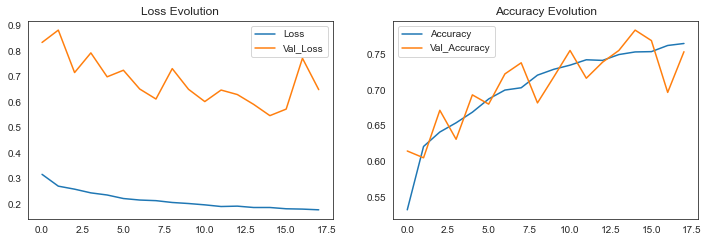

In [126]:
acclossplot(trainbase2rms)

In [127]:
basepredrms = basemodelrms.predict(testfl)
basepredrms = np.argmax(basepredrms,axis = 1)
print(classification_report(testfl.classes, basepredrms, target_names = categories))
report = classification_report(testfl.classes, basepredrms, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 14s 737ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.70      0.95      0.80       556
      NORMAL       0.87      0.91      0.89       316
       VIRAL       0.89      0.23      0.37       298

    accuracy                           0.76      1170
   macro avg       0.82      0.70      0.69      1170
weighted avg       0.79      0.76      0.72      1170



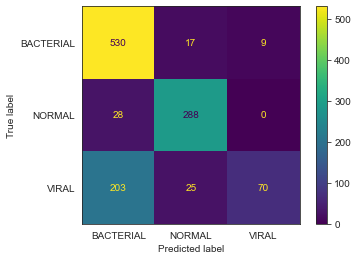

In [128]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, basepredrms), display_labels=categories)
disp.plot()

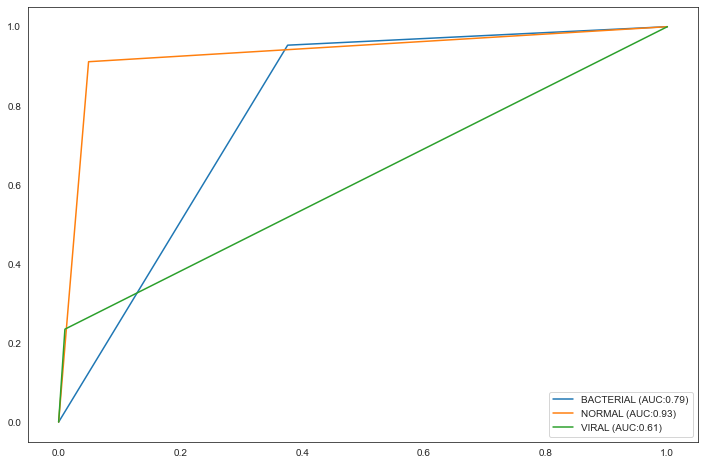

In [129]:
roc = multiclass_roc_auc_score(testfl.classes, basepredrms)

In [130]:
comparisondf.loc[len(comparisondf)] = ['CNN-RMSPROP-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035


# VGG model

In [47]:
from keras.models import Sequential
from keras.applications import VGG16

vgg16_base_model = VGG16(input_shape=shape,include_top=False,weights='imagenet')

In [48]:
tf.keras.backend.clear_session()
vgmodel = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(3,activation="softmax")
    ])
modelcompile(vgmodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [52]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_vgg')
trainvgg = vgmodel.fit(
          trainfl,
          epochs=20,
          validation_data=valfl,
          validation_steps = valfl.samples // batch_size,
          class_weight=class_weight,
          steps_per_epoch = trainfl.samples // batch_size,
          #callbacks = [es,ck])
        )
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
36/73 [=============>................] - ETA: 25s - loss: 0.5289 - accuracy: 0.4082 - categorical_crossentropy: 1.4322

KeyboardInterrupt: 

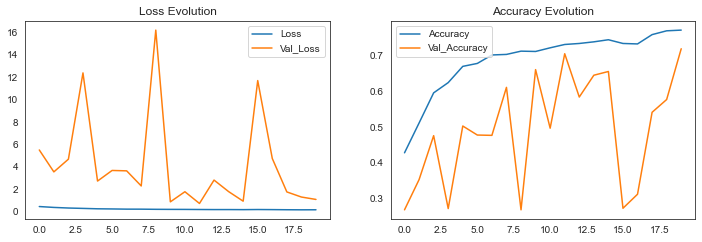

In [143]:
acclossplot(trainvgg)

In [144]:
vgpred = vgmodel.predict(testfl)
vgpred = np.argmax(vgpred,axis = 1)
print(classification_report(testfl.classes, vgpred, target_names = categories))
report = classification_report(testfl.classes, vgpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 14s 758ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.64      0.99      0.78       556
      NORMAL       0.95      0.93      0.94       316
       VIRAL       0.00      0.00      0.00       298

    accuracy                           0.72      1170
   macro avg       0.53      0.64      0.57      1170
weighted avg       0.56      0.72      0.63      1170



C:\Users\USER-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER-PC\anaconda3\lib\site-packages\skle

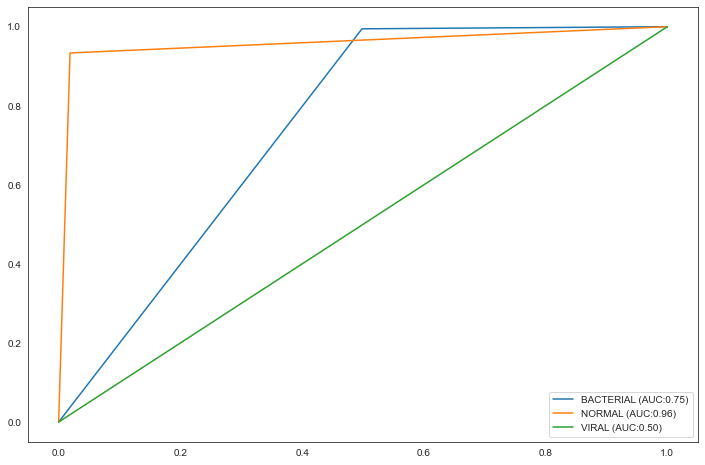

In [145]:
roc = multiclass_roc_auc_score(testfl.classes, vgpred)

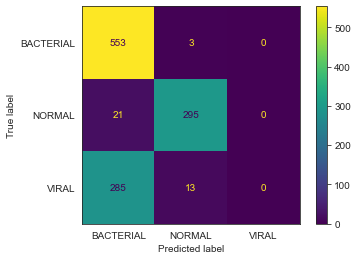

In [146]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, vgpred), display_labels=categories)
disp.plot()

In [147]:
comparisondf.loc[len(comparisondf)] = ['VGG-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701


## VGG RMSPROP

In [53]:
tf.keras.backend.clear_session()
vgmodel2 = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(3,activation="softmax")
    ])
modelcompile2(vgmodel2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [54]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_vgg')
trainvgg = vgmodel2.fit(
          trainfl,
          epochs=20,
          validation_data=valfl,
          validation_steps = valfl.samples // batch_size,
          class_weight=class_weight,
          steps_per_epoch = trainfl.samples // batch_size,
          callbacks = [es,ck]
)
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.3968 - categorical_crossentropy: 1.3241

INFO:tensorflow:Assets written to: .\ckpt_vgg\assets


INFO:tensorflow:Assets written to: .\ckpt_vgg\assets


73/73 [==============================] - 82s 1s/step - loss: 0.4816 - accuracy: 0.3968 - categorical_crossentropy: 1.3241 - val_loss: 6.2600 - val_accuracy: 0.2708 - val_categorical_crossentropy: 6.2600
Epoch 2/20
73/73 [==============================] - 85s 1s/step - loss: 0.4051 - accuracy: 0.4972 - categorical_crossentropy: 1.1285 - val_loss: 15.8340 - val_accuracy: 0.2700 - val_categorical_crossentropy: 15.8340
Epoch 3/20
73/73 [==============================] - 69s 936ms/step - loss: 0.3334 - accuracy: 0.5848 - categorical_crossentropy: 0.9581 - val_loss: 13.1219 - val_accuracy: 0.2700 - val_categorical_crossentropy: 13.1219
Epoch 4/20
73/73 [==============================] - 69s 936ms/step - loss: 0.2924 - accuracy: 0.6344 - categorical_crossentropy: 0.8522 - val_loss: 13.3982 - val_accuracy: 0.2700 - val_categorical_crossentropy: 13.3982


In [55]:
vgmodel2.save('worstmodel.h5')

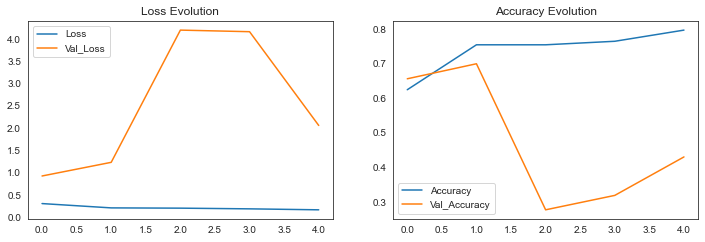

In [161]:
acclossplot(trainvgg)

In [162]:
vgpred = vgmodel2.predict(testfl)
vgpred = np.argmax(vgpred,axis = 1)
print(classification_report(testfl.classes, vgpred, target_names = categories))
report = classification_report(testfl.classes, vgpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 14s 760ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.62      0.99      0.76       556
      NORMAL       0.91      0.82      0.86       316
       VIRAL       0.00      0.00      0.00       298

    accuracy                           0.69      1170
   macro avg       0.51      0.60      0.54      1170
weighted avg       0.54      0.69      0.60      1170



C:\Users\USER-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER-PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER-PC\anaconda3\lib\site-packages\skle

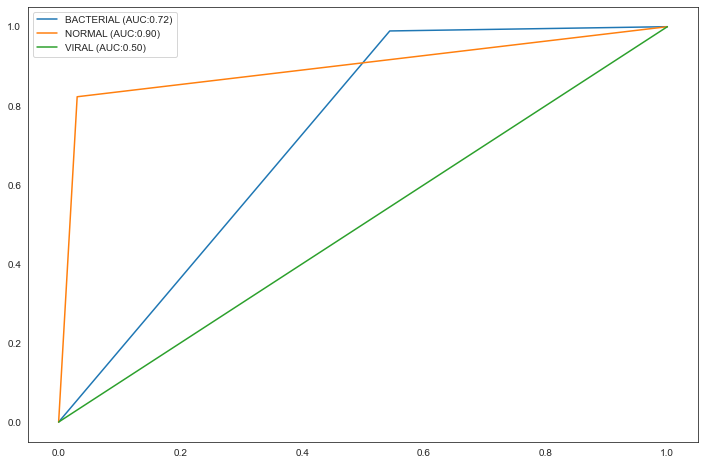

In [163]:
roc = multiclass_roc_auc_score(testfl.classes, vgpred)

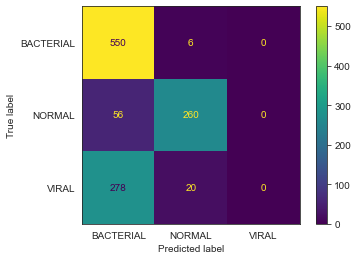

In [164]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, vgpred), display_labels=categories)
disp.plot()

In [165]:
comparisondf.loc[len(comparisondf)] = ['VGG-AUGMENTED-RMSPROP', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935


# ----------------

# Xception model

In [166]:
from tensorflow.keras.applications import Xception

base_xception = Xception(weights='imagenet', include_top=False, input_shape=shape)
base_xception.trainable = False

In [168]:
tf.keras.backend.clear_session()

xcpmodel = tf.keras.Sequential([
        base_xception,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(3,activation="softmax")
    ])
modelcompile(xcpmodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [169]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_xc')
trainxc = xcpmodel.fit(
          trainfl,
          epochs=20,
          validation_data=valfl,
          validation_steps = valfl.samples // batch_size,
          class_weight=class_weight,
          steps_per_epoch = trainfl.samples // batch_size,
          callbacks = [es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.5106 - categorical_crossentropy: 1.2057

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 87s 1s/step - loss: 0.4383 - accuracy: 0.5106 - categorical_crossentropy: 1.2057 - val_loss: 0.9264 - val_accuracy: 0.6545 - val_categorical_crossentropy: 0.9264
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.5926 - categorical_crossentropy: 0.9835

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 84s 1s/step - loss: 0.3554 - accuracy: 0.5926 - categorical_crossentropy: 0.9835 - val_loss: 0.8056 - val_accuracy: 0.6797 - val_categorical_crossentropy: 0.8056
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.6266 - categorical_crossentropy: 0.9008

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 86s 1s/step - loss: 0.3212 - accuracy: 0.6266 - categorical_crossentropy: 0.9008 - val_loss: 0.7110 - val_accuracy: 0.7205 - val_categorical_crossentropy: 0.7110
Epoch 4/20
73/73 [==============================] - 74s 1s/step - loss: 0.3073 - accuracy: 0.6426 - categorical_crossentropy: 0.8766 - val_loss: 0.7005 - val_accuracy: 0.7057 - val_categorical_crossentropy: 0.7005
Epoch 5/20
73/73 [==============================] - 76s 1s/step - loss: 0.2879 - accuracy: 0.6599 - categorical_crossentropy: 0.8289 - val_loss: 0.6925 - val_accuracy: 0.7188 - val_categorical_crossentropy: 0.6925
Epoch 6/20
73/73 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.6692 - categorical_crossentropy: 0.7963

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 88s 1s/step - loss: 0.2740 - accuracy: 0.6692 - categorical_crossentropy: 0.7963 - val_loss: 0.6691 - val_accuracy: 0.7274 - val_categorical_crossentropy: 0.6691
Epoch 7/20
73/73 [==============================] - 75s 1s/step - loss: 0.2725 - accuracy: 0.6815 - categorical_crossentropy: 0.7933 - val_loss: 0.6764 - val_accuracy: 0.7257 - val_categorical_crossentropy: 0.6764
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.7008 - categorical_crossentropy: 0.7568

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 85s 1s/step - loss: 0.2547 - accuracy: 0.7008 - categorical_crossentropy: 0.7568 - val_loss: 0.6389 - val_accuracy: 0.7396 - val_categorical_crossentropy: 0.6389
Epoch 9/20
73/73 [==============================] - 73s 1s/step - loss: 0.2444 - accuracy: 0.7012 - categorical_crossentropy: 0.7290 - val_loss: 0.6549 - val_accuracy: 0.7292 - val_categorical_crossentropy: 0.6549
Epoch 10/20
73/73 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.7042 - categorical_crossentropy: 0.7229

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 85s 1s/step - loss: 0.2400 - accuracy: 0.7042 - categorical_crossentropy: 0.7229 - val_loss: 0.6287 - val_accuracy: 0.7439 - val_categorical_crossentropy: 0.6287
Epoch 11/20
73/73 [==============================] - 75s 1s/step - loss: 0.2354 - accuracy: 0.7103 - categorical_crossentropy: 0.7163 - val_loss: 0.6506 - val_accuracy: 0.7335 - val_categorical_crossentropy: 0.6506
Epoch 12/20
73/73 [==============================] - 77s 1s/step - loss: 0.2329 - accuracy: 0.7045 - categorical_crossentropy: 0.7128 - val_loss: 0.6214 - val_accuracy: 0.7318 - val_categorical_crossentropy: 0.6214
Epoch 13/20
73/73 [==============================] - 73s 1s/step - loss: 0.2300 - accuracy: 0.7164 - categorical_crossentropy: 0.6991 - val_loss: 0.6327 - val_accuracy: 0.7387 - val_categorical_crossentropy: 0.6327


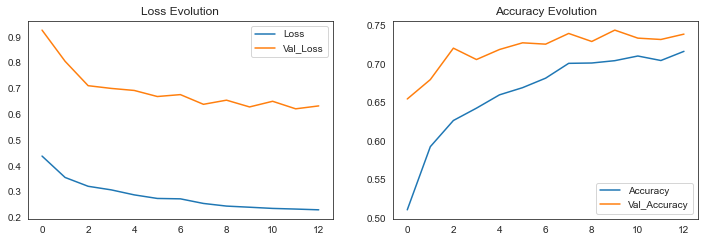

In [170]:
acclossplot(trainxc)

In [171]:
xcpred = xcpmodel.predict(testfl)
xcpred = np.argmax(xcpred,axis = 1)
print(classification_report(testfl.classes, xcpred, target_names = categories))
report = classification_report(testfl.classes, xcpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 16s 800ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.69      0.90      0.78       556
      NORMAL       0.84      0.89      0.86       316
       VIRAL       0.67      0.26      0.37       298

    accuracy                           0.73      1170
   macro avg       0.74      0.68      0.67      1170
weighted avg       0.73      0.73      0.70      1170



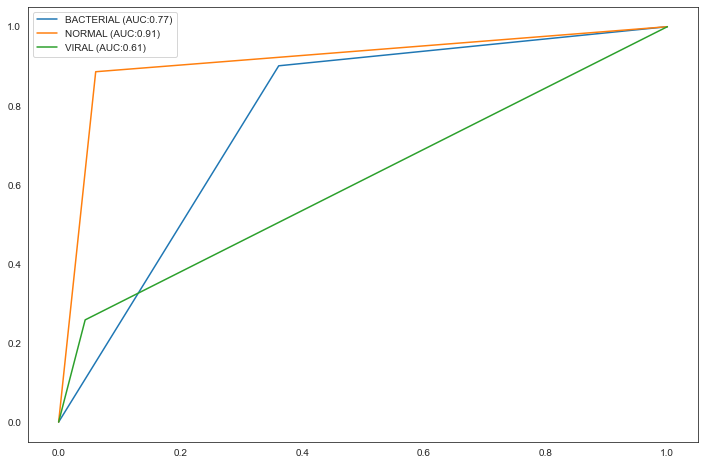

In [172]:
roc = multiclass_roc_auc_score(testfl.classes, xcpred)

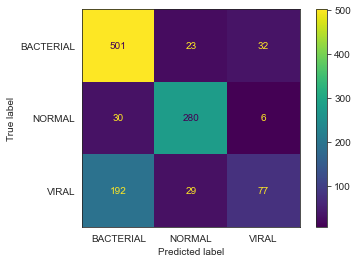

In [173]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, xcpred), display_labels=categories)
disp.plot()

In [174]:
comparisondf.loc[len(comparisondf)] = ['XCEPTION-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378


## XCEPTION RMSPROP

In [175]:
tf.keras.backend.clear_session()

xcpmodel2 = tf.keras.Sequential([
        base_xception,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.1),
        Dense(3,activation="softmax")
    ])
modelcompile2(xcpmodel2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [176]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_xc')
trainxc = xcpmodel2.fit(
          trainfl,
          epochs=20,
          validation_data=valfl,
          validation_steps = valfl.samples // batch_size,
          class_weight=class_weight,
          steps_per_epoch = trainfl.samples // batch_size,
          callbacks = [es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.4974 - categorical_crossentropy: 1.2609

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 95s 1s/step - loss: 0.4527 - accuracy: 0.4974 - categorical_crossentropy: 1.2609 - val_loss: 0.8743 - val_accuracy: 0.6615 - val_categorical_crossentropy: 0.8743
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.5956 - categorical_crossentropy: 1.0290

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 87s 1s/step - loss: 0.3661 - accuracy: 0.5956 - categorical_crossentropy: 1.0290 - val_loss: 0.8010 - val_accuracy: 0.6814 - val_categorical_crossentropy: 0.8010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.6391 - categorical_crossentropy: 0.9011

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 87s 1s/step - loss: 0.3145 - accuracy: 0.6391 - categorical_crossentropy: 0.9011 - val_loss: 0.7330 - val_accuracy: 0.7023 - val_categorical_crossentropy: 0.7330
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.6750 - categorical_crossentropy: 0.8445

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 87s 1s/step - loss: 0.2901 - accuracy: 0.6750 - categorical_crossentropy: 0.8445 - val_loss: 0.7165 - val_accuracy: 0.7170 - val_categorical_crossentropy: 0.7165
Epoch 5/20
73/73 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.6765 - categorical_crossentropy: 0.8249

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 86s 1s/step - loss: 0.2778 - accuracy: 0.6765 - categorical_crossentropy: 0.8249 - val_loss: 0.6790 - val_accuracy: 0.7240 - val_categorical_crossentropy: 0.6790
Epoch 6/20
73/73 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.6843 - categorical_crossentropy: 0.7784

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 88s 1s/step - loss: 0.2587 - accuracy: 0.6843 - categorical_crossentropy: 0.7784 - val_loss: 0.6781 - val_accuracy: 0.7292 - val_categorical_crossentropy: 0.6781
Epoch 7/20
73/73 [==============================] - 76s 1s/step - loss: 0.2547 - accuracy: 0.6908 - categorical_crossentropy: 0.7791 - val_loss: 0.6821 - val_accuracy: 0.7161 - val_categorical_crossentropy: 0.6821
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.7010 - categorical_crossentropy: 0.7366

INFO:tensorflow:Assets written to: .\ckpt_xc\assets


INFO:tensorflow:Assets written to: .\ckpt_xc\assets


73/73 [==============================] - 87s 1s/step - loss: 0.2392 - accuracy: 0.7010 - categorical_crossentropy: 0.7366 - val_loss: 0.6690 - val_accuracy: 0.7396 - val_categorical_crossentropy: 0.6690
Epoch 9/20
73/73 [==============================] - 76s 1s/step - loss: 0.2351 - accuracy: 0.7038 - categorical_crossentropy: 0.7294 - val_loss: 0.6882 - val_accuracy: 0.7309 - val_categorical_crossentropy: 0.6882
Epoch 10/20
73/73 [==============================] - 75s 1s/step - loss: 0.2261 - accuracy: 0.7159 - categorical_crossentropy: 0.7063 - val_loss: 0.6666 - val_accuracy: 0.7240 - val_categorical_crossentropy: 0.6666
Epoch 11/20
73/73 [==============================] - 75s 1s/step - loss: 0.2325 - accuracy: 0.7105 - categorical_crossentropy: 0.7296 - val_loss: 0.6371 - val_accuracy: 0.7326 - val_categorical_crossentropy: 0.6371


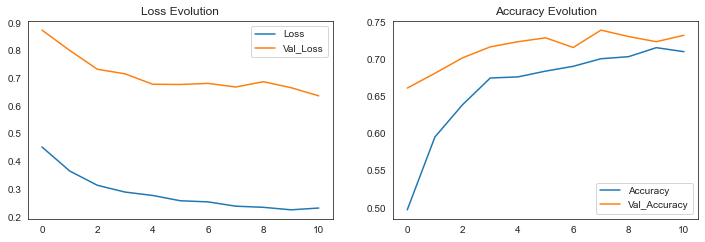

In [177]:
acclossplot(trainxc)

In [178]:
xcpred = xcpmodel2.predict(testfl)
xcpred = np.argmax(xcpred,axis = 1)
print(classification_report(testfl.classes, xcpred, target_names = categories))
report = classification_report(testfl.classes, xcpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 16s 808ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.72      0.82      0.76       556
      NORMAL       0.75      0.89      0.81       316
       VIRAL       0.63      0.34      0.44       298

    accuracy                           0.71      1170
   macro avg       0.70      0.68      0.67      1170
weighted avg       0.70      0.71      0.69      1170



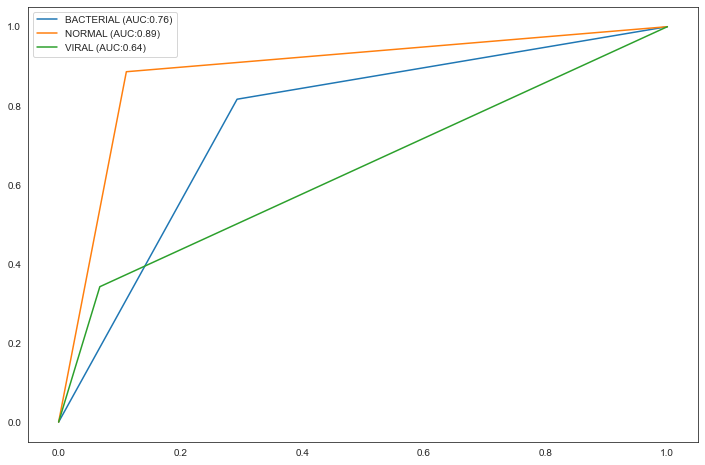

In [179]:
roc = multiclass_roc_auc_score(testfl.classes, xcpred)

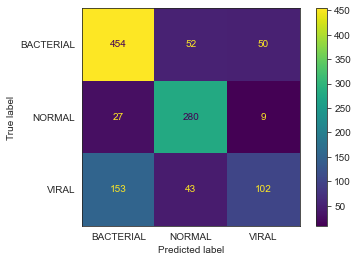

In [180]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, xcpred), display_labels=categories)
disp.plot()

In [181]:
comparisondf.loc[len(comparisondf)] = ['XCEPTION-AUGMENTED-RMSPROP', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625


# DenseNet model

In [183]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

In [184]:
base_modeldn = DenseNet121(input_shape=shape, include_top=False, weights='imagenet')
base_modeldn.trainable = False
#base_model.summary()

In [188]:
tf.keras.backend.clear_session()
dnmodel = tf.keras.Sequential([
        base_modeldn,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(3,activation="softmax")
    ])
modelcompile(dnmodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [189]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_dn')
traindn = dnmodel.fit(
        trainfl, 
        epochs=20,
        validation_data = valfl,
        validation_steps = valfl.samples // batch_size,
        class_weight=class_weight,
        steps_per_epoch = trainfl.samples // batch_size,
        callbacks = [es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/10
73/73 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.4593 - categorical_crossentropy: 1.3173

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 113s 1s/step - loss: 0.4772 - accuracy: 0.4593 - categorical_crossentropy: 1.3173 - val_loss: 0.9735 - val_accuracy: 0.5026 - val_categorical_crossentropy: 0.9735
Epoch 2/10
73/73 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.5716 - categorical_crossentropy: 1.0108

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 107s 1s/step - loss: 0.3646 - accuracy: 0.5716 - categorical_crossentropy: 1.0108 - val_loss: 0.8830 - val_accuracy: 0.6068 - val_categorical_crossentropy: 0.8830
Epoch 3/10
73/73 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.6261 - categorical_crossentropy: 0.9099

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 114s 2s/step - loss: 0.3203 - accuracy: 0.6261 - categorical_crossentropy: 0.9099 - val_loss: 0.7302 - val_accuracy: 0.7214 - val_categorical_crossentropy: 0.7302
Epoch 4/10
73/73 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.6508 - categorical_crossentropy: 0.8556

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 114s 2s/step - loss: 0.3019 - accuracy: 0.6508 - categorical_crossentropy: 0.8556 - val_loss: 0.6967 - val_accuracy: 0.7240 - val_categorical_crossentropy: 0.6967
Epoch 5/10
73/73 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.6703 - categorical_crossentropy: 0.8171

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 113s 2s/step - loss: 0.2823 - accuracy: 0.6703 - categorical_crossentropy: 0.8171 - val_loss: 0.6848 - val_accuracy: 0.7344 - val_categorical_crossentropy: 0.6848
Epoch 6/10
73/73 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.6807 - categorical_crossentropy: 0.7955

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 112s 2s/step - loss: 0.2720 - accuracy: 0.6807 - categorical_crossentropy: 0.7955 - val_loss: 0.6506 - val_accuracy: 0.7396 - val_categorical_crossentropy: 0.6506
Epoch 7/10
73/73 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.7120 - categorical_crossentropy: 0.7637

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 117s 2s/step - loss: 0.2590 - accuracy: 0.7120 - categorical_crossentropy: 0.7637 - val_loss: 0.6590 - val_accuracy: 0.7491 - val_categorical_crossentropy: 0.6590
Epoch 8/10
73/73 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.6971 - categorical_crossentropy: 0.7420

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 131s 2s/step - loss: 0.2503 - accuracy: 0.6971 - categorical_crossentropy: 0.7420 - val_loss: 0.6361 - val_accuracy: 0.7543 - val_categorical_crossentropy: 0.6361
Epoch 9/10
73/73 [==============================] - 82s 1s/step - loss: 0.2443 - accuracy: 0.7129 - categorical_crossentropy: 0.7350 - val_loss: 0.6486 - val_accuracy: 0.7396 - val_categorical_crossentropy: 0.6486
Epoch 10/10
73/73 [==============================] - 81s 1s/step - loss: 0.2328 - accuracy: 0.7239 - categorical_crossentropy: 0.7049 - val_loss: 0.6285 - val_accuracy: 0.7439 - val_categorical_crossentropy: 0.6285


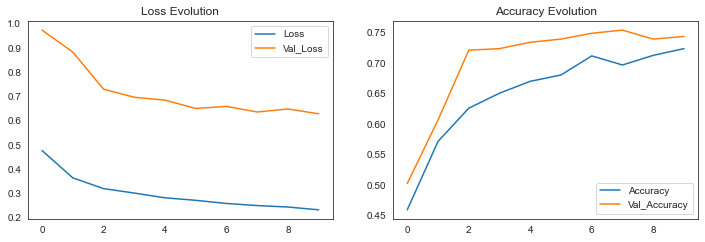

In [190]:
acclossplot(traindn)

In [191]:
dnpred = dnmodel.predict(testfl)
dnpred = np.argmax(dnpred,axis = 1)
print(classification_report(testfl.classes, dnpred, target_names = categories))
report = classification_report(testfl.classes, dnpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 17s 849ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.72      0.87      0.79       556
      NORMAL       0.86      0.85      0.86       316
       VIRAL       0.61      0.37      0.46       298

    accuracy                           0.74      1170
   macro avg       0.73      0.70      0.70      1170
weighted avg       0.73      0.74      0.72      1170



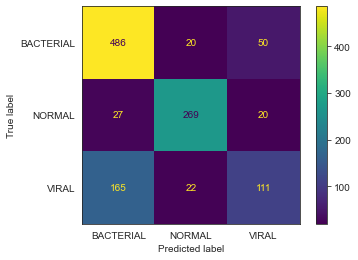

In [192]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, dnpred), display_labels=categories)
disp.plot()

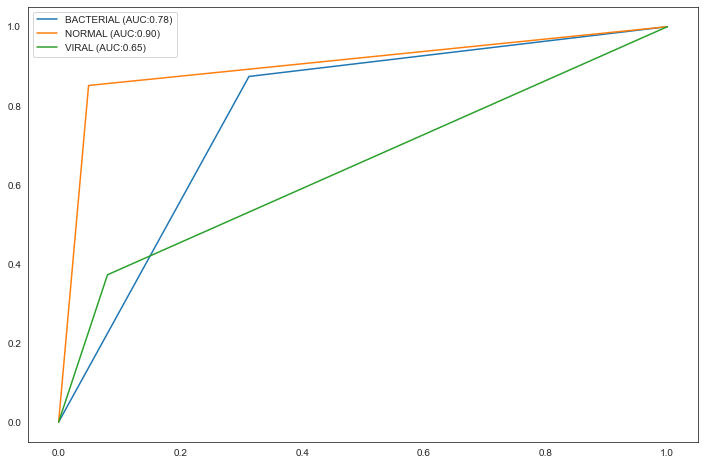

In [193]:
roc = multiclass_roc_auc_score(testfl.classes, dnpred)

In [194]:
comparisondf.loc[len(comparisondf)] = ['DENSENET-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625
8,DENSENET-AUGMENTED,0.73,0.70,0.70,0.74,0.775948,0:18:04.419547


## DenseNet RMSPROP

In [196]:
tf.keras.backend.clear_session()
dnmodel2 = tf.keras.Sequential([
        base_modeldn,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        Dense(3,activation="softmax")
    ])
modelcompile2(dnmodel2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [198]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_dn')
traindn2 = dnmodel2.fit(
        trainfl, 
        epochs=20,
        validation_data = valfl,
        validation_steps = valfl.samples // batch_size,
        class_weight=class_weight,
        steps_per_epoch = trainfl.samples // batch_size,
        callbacks = [es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.4851 - categorical_crossentropy: 1.2496

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 114s 2s/step - loss: 0.4477 - accuracy: 0.4851 - categorical_crossentropy: 1.2496 - val_loss: 1.0766 - val_accuracy: 0.5174 - val_categorical_crossentropy: 1.0766
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.5679 - categorical_crossentropy: 1.0552

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 116s 2s/step - loss: 0.3740 - accuracy: 0.5679 - categorical_crossentropy: 1.0552 - val_loss: 0.7902 - val_accuracy: 0.6745 - val_categorical_crossentropy: 0.7902
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.6160 - categorical_crossentropy: 0.9426

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 117s 2s/step - loss: 0.3249 - accuracy: 0.6160 - categorical_crossentropy: 0.9426 - val_loss: 0.7716 - val_accuracy: 0.6849 - val_categorical_crossentropy: 0.7716
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.6480 - categorical_crossentropy: 0.8733

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 119s 2s/step - loss: 0.2981 - accuracy: 0.6480 - categorical_crossentropy: 0.8733 - val_loss: 0.7303 - val_accuracy: 0.7127 - val_categorical_crossentropy: 0.7303
Epoch 5/20
73/73 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.6750 - categorical_crossentropy: 0.8367

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 120s 2s/step - loss: 0.2806 - accuracy: 0.6750 - categorical_crossentropy: 0.8367 - val_loss: 0.7037 - val_accuracy: 0.7240 - val_categorical_crossentropy: 0.7037
Epoch 6/20
73/73 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.6869 - categorical_crossentropy: 0.7889

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 118s 2s/step - loss: 0.2612 - accuracy: 0.6869 - categorical_crossentropy: 0.7889 - val_loss: 0.6913 - val_accuracy: 0.7300 - val_categorical_crossentropy: 0.6913
Epoch 7/20
73/73 [==============================] - 91s 1s/step - loss: 0.2432 - accuracy: 0.6923 - categorical_crossentropy: 0.7497 - val_loss: 0.6629 - val_accuracy: 0.7240 - val_categorical_crossentropy: 0.6629
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.7062 - categorical_crossentropy: 0.7370

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 125s 2s/step - loss: 0.2383 - accuracy: 0.7062 - categorical_crossentropy: 0.7370 - val_loss: 0.6200 - val_accuracy: 0.7465 - val_categorical_crossentropy: 0.6200
Epoch 9/20
73/73 [==============================] - 88s 1s/step - loss: 0.2293 - accuracy: 0.7114 - categorical_crossentropy: 0.7177 - val_loss: 0.6440 - val_accuracy: 0.7257 - val_categorical_crossentropy: 0.6440
Epoch 10/20
73/73 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.7237 - categorical_crossentropy: 0.7059

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 117s 2s/step - loss: 0.2278 - accuracy: 0.7237 - categorical_crossentropy: 0.7059 - val_loss: 0.6165 - val_accuracy: 0.7491 - val_categorical_crossentropy: 0.6165
Epoch 11/20
73/73 [==============================] - 85s 1s/step - loss: 0.2186 - accuracy: 0.7257 - categorical_crossentropy: 0.6892 - val_loss: 0.6562 - val_accuracy: 0.7214 - val_categorical_crossentropy: 0.6562
Epoch 12/20
73/73 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.7356 - categorical_crossentropy: 0.6837

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 119s 2s/step - loss: 0.2168 - accuracy: 0.7356 - categorical_crossentropy: 0.6837 - val_loss: 0.6133 - val_accuracy: 0.7509 - val_categorical_crossentropy: 0.6133
Epoch 13/20
73/73 [==============================] - 89s 1s/step - loss: 0.2062 - accuracy: 0.7367 - categorical_crossentropy: 0.6545 - val_loss: 0.6400 - val_accuracy: 0.7335 - val_categorical_crossentropy: 0.6400
Epoch 14/20
73/73 [==============================] - 93s 1s/step - loss: 0.2086 - accuracy: 0.7382 - categorical_crossentropy: 0.6586 - val_loss: 0.5944 - val_accuracy: 0.7457 - val_categorical_crossentropy: 0.5944
Epoch 15/20
73/73 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.7389 - categorical_crossentropy: 0.6488

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 122s 2s/step - loss: 0.2068 - accuracy: 0.7389 - categorical_crossentropy: 0.6488 - val_loss: 0.6369 - val_accuracy: 0.7587 - val_categorical_crossentropy: 0.6369
Epoch 16/20
73/73 [==============================] - 83s 1s/step - loss: 0.2044 - accuracy: 0.7393 - categorical_crossentropy: 0.6429 - val_loss: 0.6096 - val_accuracy: 0.7457 - val_categorical_crossentropy: 0.6096
Epoch 17/20
73/73 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.7428 - categorical_crossentropy: 0.6460

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 123s 2s/step - loss: 0.2044 - accuracy: 0.7428 - categorical_crossentropy: 0.6460 - val_loss: 0.5844 - val_accuracy: 0.7648 - val_categorical_crossentropy: 0.5844
Epoch 18/20
73/73 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.7430 - categorical_crossentropy: 0.6272

INFO:tensorflow:Assets written to: .\ckpt_dn\assets


INFO:tensorflow:Assets written to: .\ckpt_dn\assets


73/73 [==============================] - 135s 2s/step - loss: 0.1964 - accuracy: 0.7430 - categorical_crossentropy: 0.6272 - val_loss: 0.5669 - val_accuracy: 0.7760 - val_categorical_crossentropy: 0.5669
Epoch 19/20
73/73 [==============================] - 102s 1s/step - loss: 0.1989 - accuracy: 0.7451 - categorical_crossentropy: 0.6341 - val_loss: 0.5625 - val_accuracy: 0.7622 - val_categorical_crossentropy: 0.5625
Epoch 20/20
73/73 [==============================] - 102s 1s/step - loss: 0.1984 - accuracy: 0.7410 - categorical_crossentropy: 0.6279 - val_loss: 0.5749 - val_accuracy: 0.7491 - val_categorical_crossentropy: 0.5749


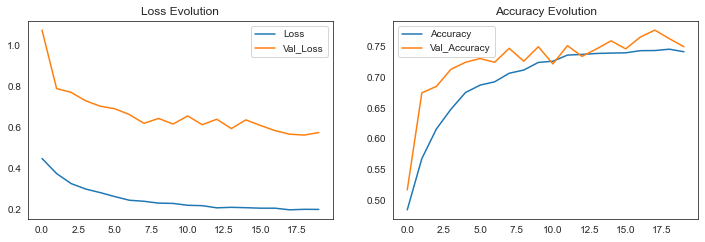

In [199]:
acclossplot(traindn2)

In [200]:
dnpred = dnmodel2.predict(testfl)
dnpred = np.argmax(dnpred,axis = 1)
print(classification_report(testfl.classes, dnpred, target_names = categories))
report = classification_report(testfl.classes, dnpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 19s 926ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.71      0.93      0.81       556
      NORMAL       0.88      0.91      0.89       316
       VIRAL       0.80      0.32      0.45       298

    accuracy                           0.77      1170
   macro avg       0.80      0.72      0.72      1170
weighted avg       0.78      0.77      0.74      1170



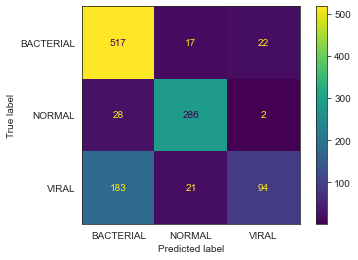

In [201]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, dnpred), display_labels=categories)
disp.plot()

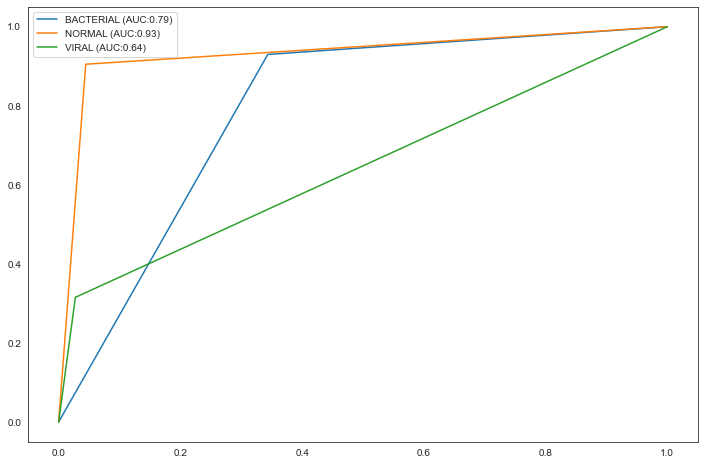

In [202]:
roc = multiclass_roc_auc_score(testfl.classes, dnpred)

In [203]:
comparisondf.loc[len(comparisondf)] = ['DENSENET-AUGMENTED-RMSPROP', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625
8,DENSENET-AUGMENTED,0.73,0.70,0.70,0.74,0.775948,0:18:04.419547
9,DENSENET-AUGMENTED-RMSPROP,0.80,0.72,0.72,0.77,0.789115,0:36:19.167236


# ResNet Model

In [204]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=shape, include_top=False, weights='imagenet')
resnet_base_model.trainable = False

In [205]:
tf.keras.backend.clear_session()
rnmodel = tf.keras.Sequential([
    resnet_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3,activation="softmax")
])

modelcompile(rnmodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [208]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_rn')
trainrn = rnmodel.fit(
        trainfl, 
        epochs=20,
        validation_data = valfl,
        validation_steps = valfl.samples // batch_size,
        class_weight=class_weight,
        steps_per_epoch = trainfl.samples // batch_size,
        callbacks = [es,ck]
)
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.5385 - categorical_crossentropy: 1.0528

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 102s 1s/step - loss: 0.3778 - accuracy: 0.5385 - categorical_crossentropy: 1.0528 - val_loss: 0.8205 - val_accuracy: 0.6615 - val_categorical_crossentropy: 0.8205
Epoch 2/20
73/73 [==============================] - 83s 1s/step - loss: 0.3630 - accuracy: 0.5634 - categorical_crossentropy: 1.0092 - val_loss: 0.8040 - val_accuracy: 0.6502 - val_categorical_crossentropy: 0.8040
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.5744 - categorical_crossentropy: 0.9856

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 98s 1s/step - loss: 0.3470 - accuracy: 0.5744 - categorical_crossentropy: 0.9856 - val_loss: 0.7634 - val_accuracy: 0.6771 - val_categorical_crossentropy: 0.7634
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.5766 - categorical_crossentropy: 0.9689

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 99s 1s/step - loss: 0.3393 - accuracy: 0.5766 - categorical_crossentropy: 0.9689 - val_loss: 0.7370 - val_accuracy: 0.6910 - val_categorical_crossentropy: 0.7370
Epoch 5/20
73/73 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.6103 - categorical_crossentropy: 0.9133

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 98s 1s/step - loss: 0.3188 - accuracy: 0.6103 - categorical_crossentropy: 0.9133 - val_loss: 0.7279 - val_accuracy: 0.6927 - val_categorical_crossentropy: 0.7279
Epoch 6/20
73/73 [==============================] - 83s 1s/step - loss: 0.3128 - accuracy: 0.6123 - categorical_crossentropy: 0.8993 - val_loss: 0.7669 - val_accuracy: 0.6814 - val_categorical_crossentropy: 0.7669
Epoch 7/20
73/73 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.6283 - categorical_crossentropy: 0.8740

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 100s 1s/step - loss: 0.2998 - accuracy: 0.6283 - categorical_crossentropy: 0.8740 - val_loss: 0.7715 - val_accuracy: 0.6997 - val_categorical_crossentropy: 0.7715
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.6385 - categorical_crossentropy: 0.8605

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 105s 1s/step - loss: 0.2931 - accuracy: 0.6385 - categorical_crossentropy: 0.8605 - val_loss: 0.7425 - val_accuracy: 0.7170 - val_categorical_crossentropy: 0.7425
Epoch 9/20
73/73 [==============================] - 101s 1s/step - loss: 0.2890 - accuracy: 0.6292 - categorical_crossentropy: 0.8525 - val_loss: 0.8200 - val_accuracy: 0.6554 - val_categorical_crossentropy: 0.8200
Epoch 10/20
73/73 [==============================] - 98s 1s/step - loss: 0.2830 - accuracy: 0.6428 - categorical_crossentropy: 0.8426 - val_loss: 0.6904 - val_accuracy: 0.7144 - val_categorical_crossentropy: 0.6904
Epoch 11/20
73/73 [==============================] - 95s 1s/step - loss: 0.2825 - accuracy: 0.6398 - categorical_crossentropy: 0.8463 - val_loss: 0.7253 - val_accuracy: 0.7083 - val_categorical_crossentropy: 0.7253


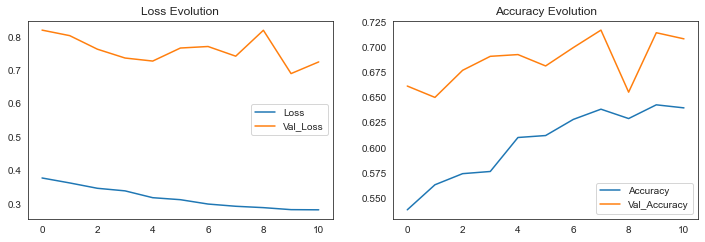

In [209]:
acclossplot(trainrn)

In [224]:
rnpred = rnmodel.predict(testfl)
rnpred = np.argmax(rnpred,axis = 1)
print(classification_report(testfl.classes, rnpred, target_names = categories))
report = classification_report(testfl.classes, rnpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 22s 1s/step
              precision    recall  f1-score   support

   BACTERIAL       0.72      0.80      0.75       556
      NORMAL       0.72      0.91      0.80       316
       VIRAL       0.61      0.31      0.41       298

    accuracy                           0.70      1170
   macro avg       0.68      0.67      0.66      1170
weighted avg       0.69      0.70      0.68      1170



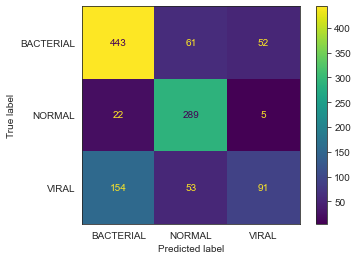

In [225]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, rnpred), display_labels=categories)
disp.plot()

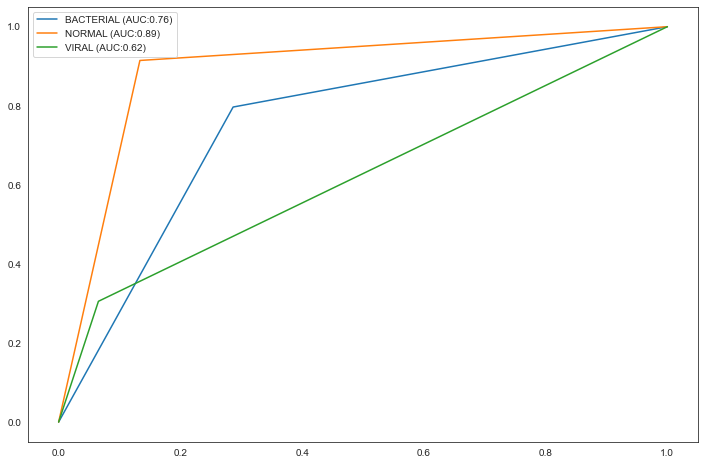

In [226]:
roc = multiclass_roc_auc_score(testfl.classes, rnpred)

In [227]:
comparisondf.loc[len(comparisondf)] = ['RESNET-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625
8,DENSENET-AUGMENTED,0.73,0.70,0.70,0.74,0.775948,0:18:04.419547
9,DENSENET-AUGMENTED-RMSPROP,0.80,0.72,0.72,0.77,0.789115,0:36:19.167236


## ResNet RMSPROP

In [215]:
tf.keras.backend.clear_session()
rnmodel2 = tf.keras.Sequential([
    resnet_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3,activation="softmax")
])

modelcompile2(rnmodel2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [229]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_rn')
trainrn2 = rnmodel2.fit(
        trainfl, 
        epochs=20,
        validation_data = valfl,
        validation_steps = valfl.samples // batch_size,
        class_weight=class_weight,
        steps_per_epoch = trainfl.samples // batch_size,
        callbacks = [es,ck]
)
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.6199 - categorical_crossentropy: 0.9309

INFO:tensorflow:Assets written to: .\ckpt_rn\assets


INFO:tensorflow:Assets written to: .\ckpt_rn\assets


73/73 [==============================] - 122s 2s/step - loss: 0.3226 - accuracy: 0.6199 - categorical_crossentropy: 0.9309 - val_loss: 0.7256 - val_accuracy: 0.7075 - val_categorical_crossentropy: 0.7256
Epoch 2/20
73/73 [==============================] - 104s 1s/step - loss: 0.3164 - accuracy: 0.6207 - categorical_crossentropy: 0.9163 - val_loss: 0.7411 - val_accuracy: 0.6979 - val_categorical_crossentropy: 0.7411
Epoch 3/20
73/73 [==============================] - 102s 1s/step - loss: 0.3105 - accuracy: 0.6318 - categorical_crossentropy: 0.9124 - val_loss: 0.7437 - val_accuracy: 0.6953 - val_categorical_crossentropy: 0.7437
Epoch 4/20
73/73 [==============================] - 101s 1s/step - loss: 0.2908 - accuracy: 0.6406 - categorical_crossentropy: 0.8664 - val_loss: 0.7286 - val_accuracy: 0.6997 - val_categorical_crossentropy: 0.7286


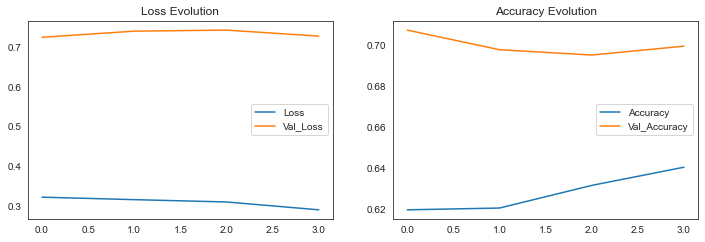

In [230]:
acclossplot(trainrn2)

In [231]:
rnpred = rnmodel2.predict(testfl)
rnpred = np.argmax(rnpred,axis = 1)
print(classification_report(testfl.classes, rnpred, target_names = categories))
report = classification_report(testfl.classes, rnpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 22s 1s/step
              precision    recall  f1-score   support

   BACTERIAL       0.72      0.80      0.76       556
      NORMAL       0.74      0.87      0.80       316
       VIRAL       0.57      0.35      0.43       298

    accuracy                           0.70      1170
   macro avg       0.68      0.67      0.66      1170
weighted avg       0.69      0.70      0.69      1170



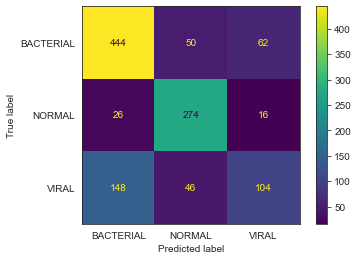

In [232]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, rnpred), display_labels=categories)
disp.plot()

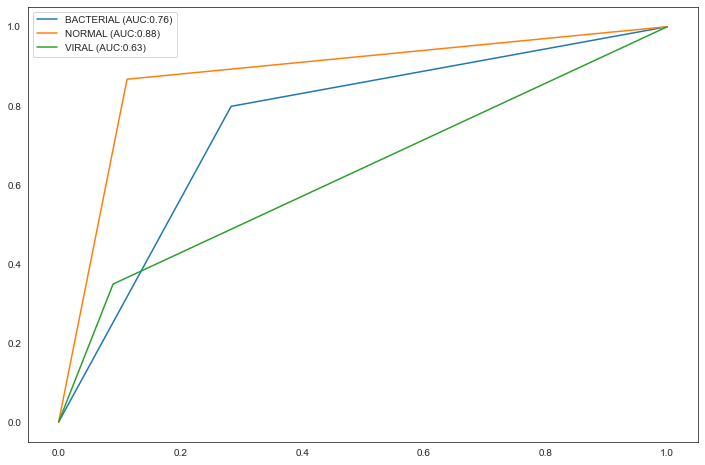

In [233]:
roc = multiclass_roc_auc_score(testfl.classes, rnpred)

In [234]:
comparisondf.loc[len(comparisondf)] = ['RESNET-AUGMENTED-RMSPROP', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625
8,DENSENET-AUGMENTED,0.73,0.70,0.70,0.74,0.775948,0:18:04.419547
9,DENSENET-AUGMENTED-RMSPROP,0.80,0.72,0.72,0.77,0.789115,0:36:19.167236


# Inception model

In [235]:
from keras.applications import InceptionV3

inception_base_model = InceptionV3(input_shape=shape,include_top=False,weights='imagenet')
inception_base_model.trainable = False

In [236]:
tf.keras.backend.clear_session()

inmodel = tf.keras.Sequential([
    inception_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3,activation="softmax")
])

modelcompile(inmodel)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [237]:
now1 = datetime.now()
es, ck = earlystop('./ckpt_in')
trainin = inmodel.fit(
        trainfl, 
        epochs=20,
        validation_data = valfl,
        validation_steps = valfl.samples // batch_size,
        class_weight=class_weight,
        steps_per_epoch = trainfl.samples // batch_size,
        callbacks = [es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - 102s 1s/step - loss: 0.6937 - accuracy: 0.3241 - categorical_crossentropy: 1.8960 - val_loss: 1.2243 - val_accuracy: 0.3151 - val_categorical_crossentropy: 1.2243
Epoch 2/20
73/73 [==============================] - 78s 1s/step - loss: 0.6238 - accuracy: 0.3659 - categorical_crossentropy: 1.7024 - val_loss: 1.2697 - val_accuracy: 0.3385 - val_categorical_crossentropy: 1.2697
Epoch 3/20
73/73 [==============================] - 78s 1s/step - loss: 0.5773 - accuracy: 0.3916 - categorical_crossentropy: 1.5893 - val_loss: 1.2415 - val_accuracy: 0.3776 - val_categorical_crossentropy: 1.2415
Epoch 4/20
73/73 [==============================] - 78s 1s/step - loss: 0.5494 - accuracy: 0.4076 - categorical_crossentropy: 1.5082 - val_loss: 1.1323 - val_accuracy: 0.4436 - val_categorical_crossentropy: 1.1323
Epoch 5/20
73/73 [==============================] - 78s 1s/step - loss: 0.5192 - accuracy: 0.4260 - categorical_crossentropy: 1.4424 - val_loss

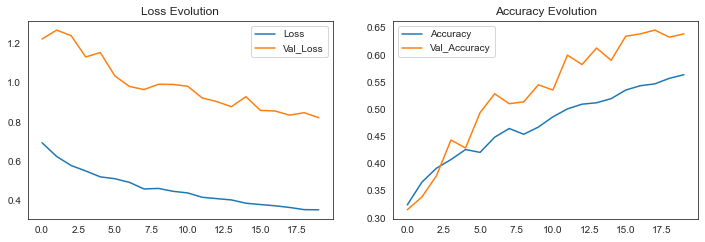

In [238]:
acclossplot(trainin)

In [239]:
inpred = inmodel.predict(testfl)
inpred = np.argmax(inpred,axis = 1)
print(classification_report(testfl.classes, inpred, target_names = categories))
report = classification_report(testfl.classes, inpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 17s 876ms/step
              precision    recall  f1-score   support

   BACTERIAL       0.71      0.79      0.75       556
      NORMAL       0.58      0.89      0.70       316
       VIRAL       0.66      0.16      0.25       298

    accuracy                           0.66      1170
   macro avg       0.65      0.61      0.57      1170
weighted avg       0.66      0.66      0.61      1170



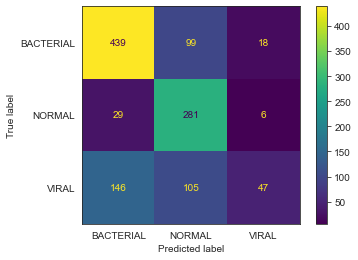

In [240]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, inpred), display_labels=categories)
disp.plot()

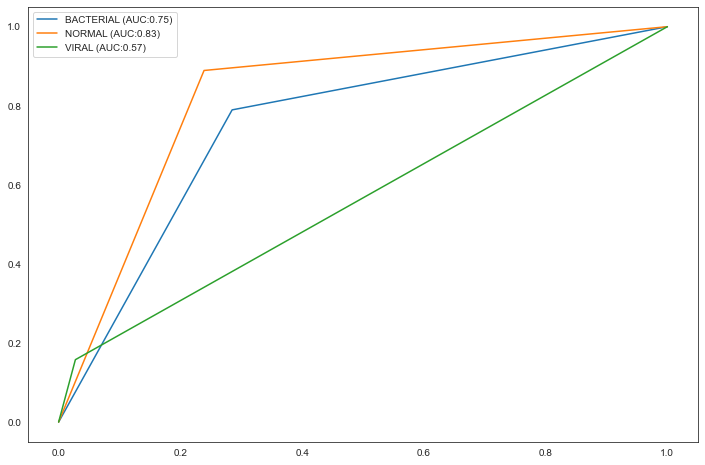

In [241]:
roc = multiclass_roc_auc_score(testfl.classes, inpred)

In [242]:
comparisondf.loc[len(comparisondf)] = ['INCEPTION-AUGMENTED', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625
8,DENSENET-AUGMENTED,0.73,0.70,0.70,0.74,0.775948,0:18:04.419547
9,DENSENET-AUGMENTED-RMSPROP,0.80,0.72,0.72,0.77,0.789115,0:36:19.167236


## Inception RMSPROP

In [248]:
tf.keras.backend.clear_session()

inmodel2 = tf.keras.Sequential([
    inception_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3,activation="softmax")
])

modelcompile2(inmodel2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [249]:
now1 = datetime.now()
trainin2 = inmodel2.fit(
        trainfl, 
        epochs=20,
        validation_data = valfl,
        validation_steps = valfl.samples // batch_size,
        class_weight=class_weight,
        steps_per_epoch = trainfl.samples // batch_size,
        callbacks = [es,ck])
now2 = datetime.now()
now3 = now2-now1
timediff = str(':'.join(str(now3).split(':')[:3]))

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.4654 - categorical_crossentropy: 1.2379

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 111s 1s/step - loss: 0.4489 - accuracy: 0.4654 - categorical_crossentropy: 1.2379 - val_loss: 1.0047 - val_accuracy: 0.5148 - val_categorical_crossentropy: 1.0047
Epoch 2/20
73/73 [==============================] - 83s 1s/step - loss: 0.3716 - accuracy: 0.5617 - categorical_crossentropy: 1.0288 - val_loss: 1.0933 - val_accuracy: 0.4939 - val_categorical_crossentropy: 1.0933
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.5894 - categorical_crossentropy: 0.9668

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 122s 2s/step - loss: 0.3483 - accuracy: 0.5894 - categorical_crossentropy: 0.9668 - val_loss: 0.8988 - val_accuracy: 0.6337 - val_categorical_crossentropy: 0.8988
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.6093 - categorical_crossentropy: 0.9455

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 121s 2s/step - loss: 0.3351 - accuracy: 0.6093 - categorical_crossentropy: 0.9455 - val_loss: 0.8336 - val_accuracy: 0.6632 - val_categorical_crossentropy: 0.8336
Epoch 5/20
73/73 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.6404 - categorical_crossentropy: 0.8606

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 124s 2s/step - loss: 0.3024 - accuracy: 0.6404 - categorical_crossentropy: 0.8606 - val_loss: 0.8209 - val_accuracy: 0.6641 - val_categorical_crossentropy: 0.8209
Epoch 6/20
73/73 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.6495 - categorical_crossentropy: 0.8509

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 126s 2s/step - loss: 0.2948 - accuracy: 0.6495 - categorical_crossentropy: 0.8509 - val_loss: 0.7690 - val_accuracy: 0.6953 - val_categorical_crossentropy: 0.7690
Epoch 7/20
73/73 [==============================] - 98s 1s/step - loss: 0.2777 - accuracy: 0.6714 - categorical_crossentropy: 0.8068 - val_loss: 0.7218 - val_accuracy: 0.6910 - val_categorical_crossentropy: 0.7218
Epoch 8/20
73/73 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.6833 - categorical_crossentropy: 0.7992

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 123s 2s/step - loss: 0.2736 - accuracy: 0.6833 - categorical_crossentropy: 0.7992 - val_loss: 0.7105 - val_accuracy: 0.7109 - val_categorical_crossentropy: 0.7105
Epoch 9/20
73/73 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.6848 - categorical_crossentropy: 0.7923

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 125s 2s/step - loss: 0.2675 - accuracy: 0.6848 - categorical_crossentropy: 0.7923 - val_loss: 0.6926 - val_accuracy: 0.7231 - val_categorical_crossentropy: 0.6926
Epoch 10/20
73/73 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.6947 - categorical_crossentropy: 0.7503

INFO:tensorflow:Assets written to: .\ckpt_in\assets


INFO:tensorflow:Assets written to: .\ckpt_in\assets


73/73 [==============================] - 120s 2s/step - loss: 0.2527 - accuracy: 0.6947 - categorical_crossentropy: 0.7503 - val_loss: 0.6887 - val_accuracy: 0.7326 - val_categorical_crossentropy: 0.6887
Epoch 11/20
73/73 [==============================] - 102s 1s/step - loss: 0.2485 - accuracy: 0.7023 - categorical_crossentropy: 0.7463 - val_loss: 0.6885 - val_accuracy: 0.7170 - val_categorical_crossentropy: 0.6885
Epoch 12/20
73/73 [==============================] - 103s 1s/step - loss: 0.2414 - accuracy: 0.7036 - categorical_crossentropy: 0.7308 - val_loss: 0.6988 - val_accuracy: 0.7222 - val_categorical_crossentropy: 0.6988
Epoch 13/20
73/73 [==============================] - 101s 1s/step - loss: 0.2355 - accuracy: 0.7161 - categorical_crossentropy: 0.7171 - val_loss: 0.6480 - val_accuracy: 0.7231 - val_categorical_crossentropy: 0.6480


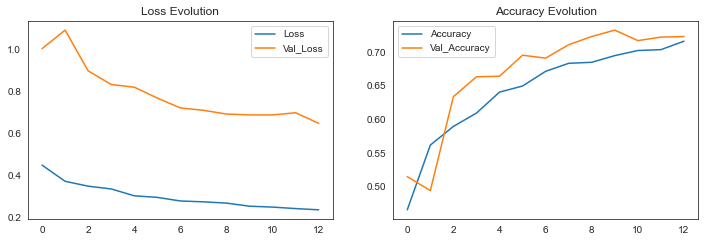

In [250]:
acclossplot(trainin2)

In [251]:
inpred = inmodel2.predict(testfl)
inpred = np.argmax(inpred,axis = 1)
print(classification_report(testfl.classes, inpred, target_names = categories))
report = classification_report(testfl.classes, inpred, target_names = categories, output_dict=True)
precision, recall, f1, accuracy = classreport(report)

19/19 [==============================] - 21s 1s/step
              precision    recall  f1-score   support

   BACTERIAL       0.75      0.81      0.78       556
      NORMAL       0.77      0.93      0.84       316
       VIRAL       0.61      0.39      0.47       298

    accuracy                           0.73      1170
   macro avg       0.71      0.71      0.70      1170
weighted avg       0.72      0.73      0.72      1170



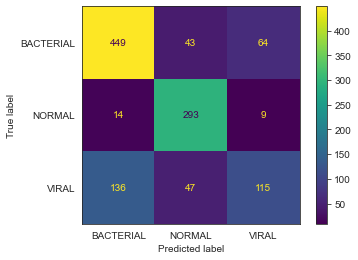

In [252]:
disp = ConfusionMatrixDisplay(confusion_matrix(testfl.classes, inpred), display_labels=categories)
disp.plot()

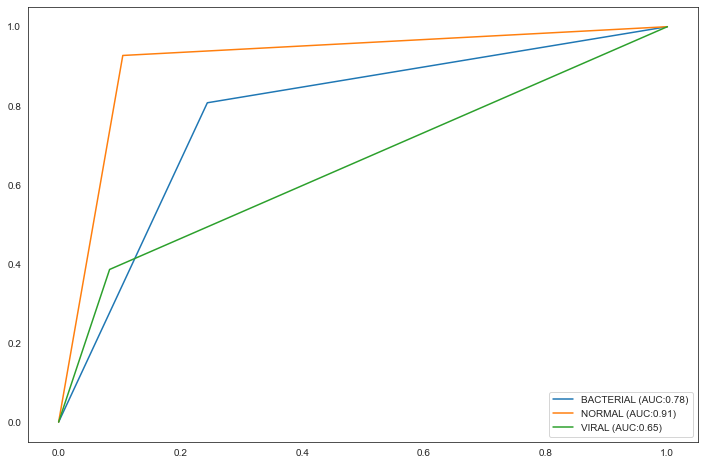

In [253]:
roc = multiclass_roc_auc_score(testfl.classes, inpred)

In [254]:
comparisondf.loc[len(comparisondf)] = ['INCEPTION-AUGMENTED-RMSPROP', precision, recall, f1, accuracy, roc,  timediff]
comparisondf

,Model,Precision,Recall,F1,Accuracy,ROC AUC score,Training Time
0,CNN-ADAM,0.80,0.76,0.77,0.80,0.822356,0:01:49.082736
1,CNN-RMSPROP,0.79,0.75,0.75,0.79,0.811738,0:01:42.196511
2,CNN-ADAM-AUGMENTED,0.78,0.68,0.66,0.74,0.761684,0:19:03.123096
3,CNN-RMSPROP-AUGMENTED,0.82,0.70,0.69,0.76,0.777301,0:21:45.760035
4,VGG-AUGMENTED,0.53,0.64,0.57,0.72,0.735174,0:24:07.859701
5,VGG-AUGMENTED-RMSPROP,0.51,0.60,0.54,0.69,0.706262,0:06:21.450935
6,XCEPTION-AUGMENTED,0.74,0.68,0.67,0.73,0.763252,0:17:19.512378
7,XCEPTION-AUGMENTED-RMSPROP,0.70,0.68,0.67,0.71,0.762141,0:15:20.002625
8,DENSENET-AUGMENTED,0.73,0.70,0.70,0.74,0.775948,0:18:04.419547
9,DENSENET-AUGMENTED-RMSPROP,0.80,0.72,0.72,0.77,0.789115,0:36:19.167236


### Issues / Improvements
1. Dataset is imbalanced
2. will apply cross-validation in next improvement
3. will add more disease classes in next improvement

### Credits

- this code is inspired by:

    HOMAYOON KHADIVI - Medical Diagnosis with CNN& Transfer Learning
    
    https://www.kaggle.com/code/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning
    
    Dr. Youakim Badr - Assignment 2 solution
    
    https://psu.instructure.com/courses/2215840/files/142471838?module_item_id=37091567&fd_cookie_set=1